<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Advanced Time Series Analysis</h1>
<h1>ARIMA Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import statsmodels.api as sm

import tqdm
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

import matplotlib
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

json            2.0.9
matplotlib      3.1.3
autopep8        1.5
numpy           1.18.1
pandas          1.0.1
statsmodels.api 0.11.1
watermark       2.0.2
Wed Aug 12 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ad113ebccef84746db0546ef024c357d7cba54ca


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ARIMA Model Fitting

In [4]:
ILI = pd.read_csv('data/CDC.csv')

We convert the year and week number to an actual date. For convenience, we use the Monday (day 1) when computing the date.

In [5]:
ILI['Date'] = ILI[['Year', 'Week']].apply(lambda x: "%s-%02u-1" % (x.Year, x.Week), axis=1)
ILI['Date'] = pd.to_datetime(ILI['Date'], format='%Y-%U-%w')

And extract only the information we're going to use

In [6]:
ILI = ILI[['Date', 'Percent of Deaths Due to Pneumonia and Influenza']].set_index('Date')

Our timeseries is then:

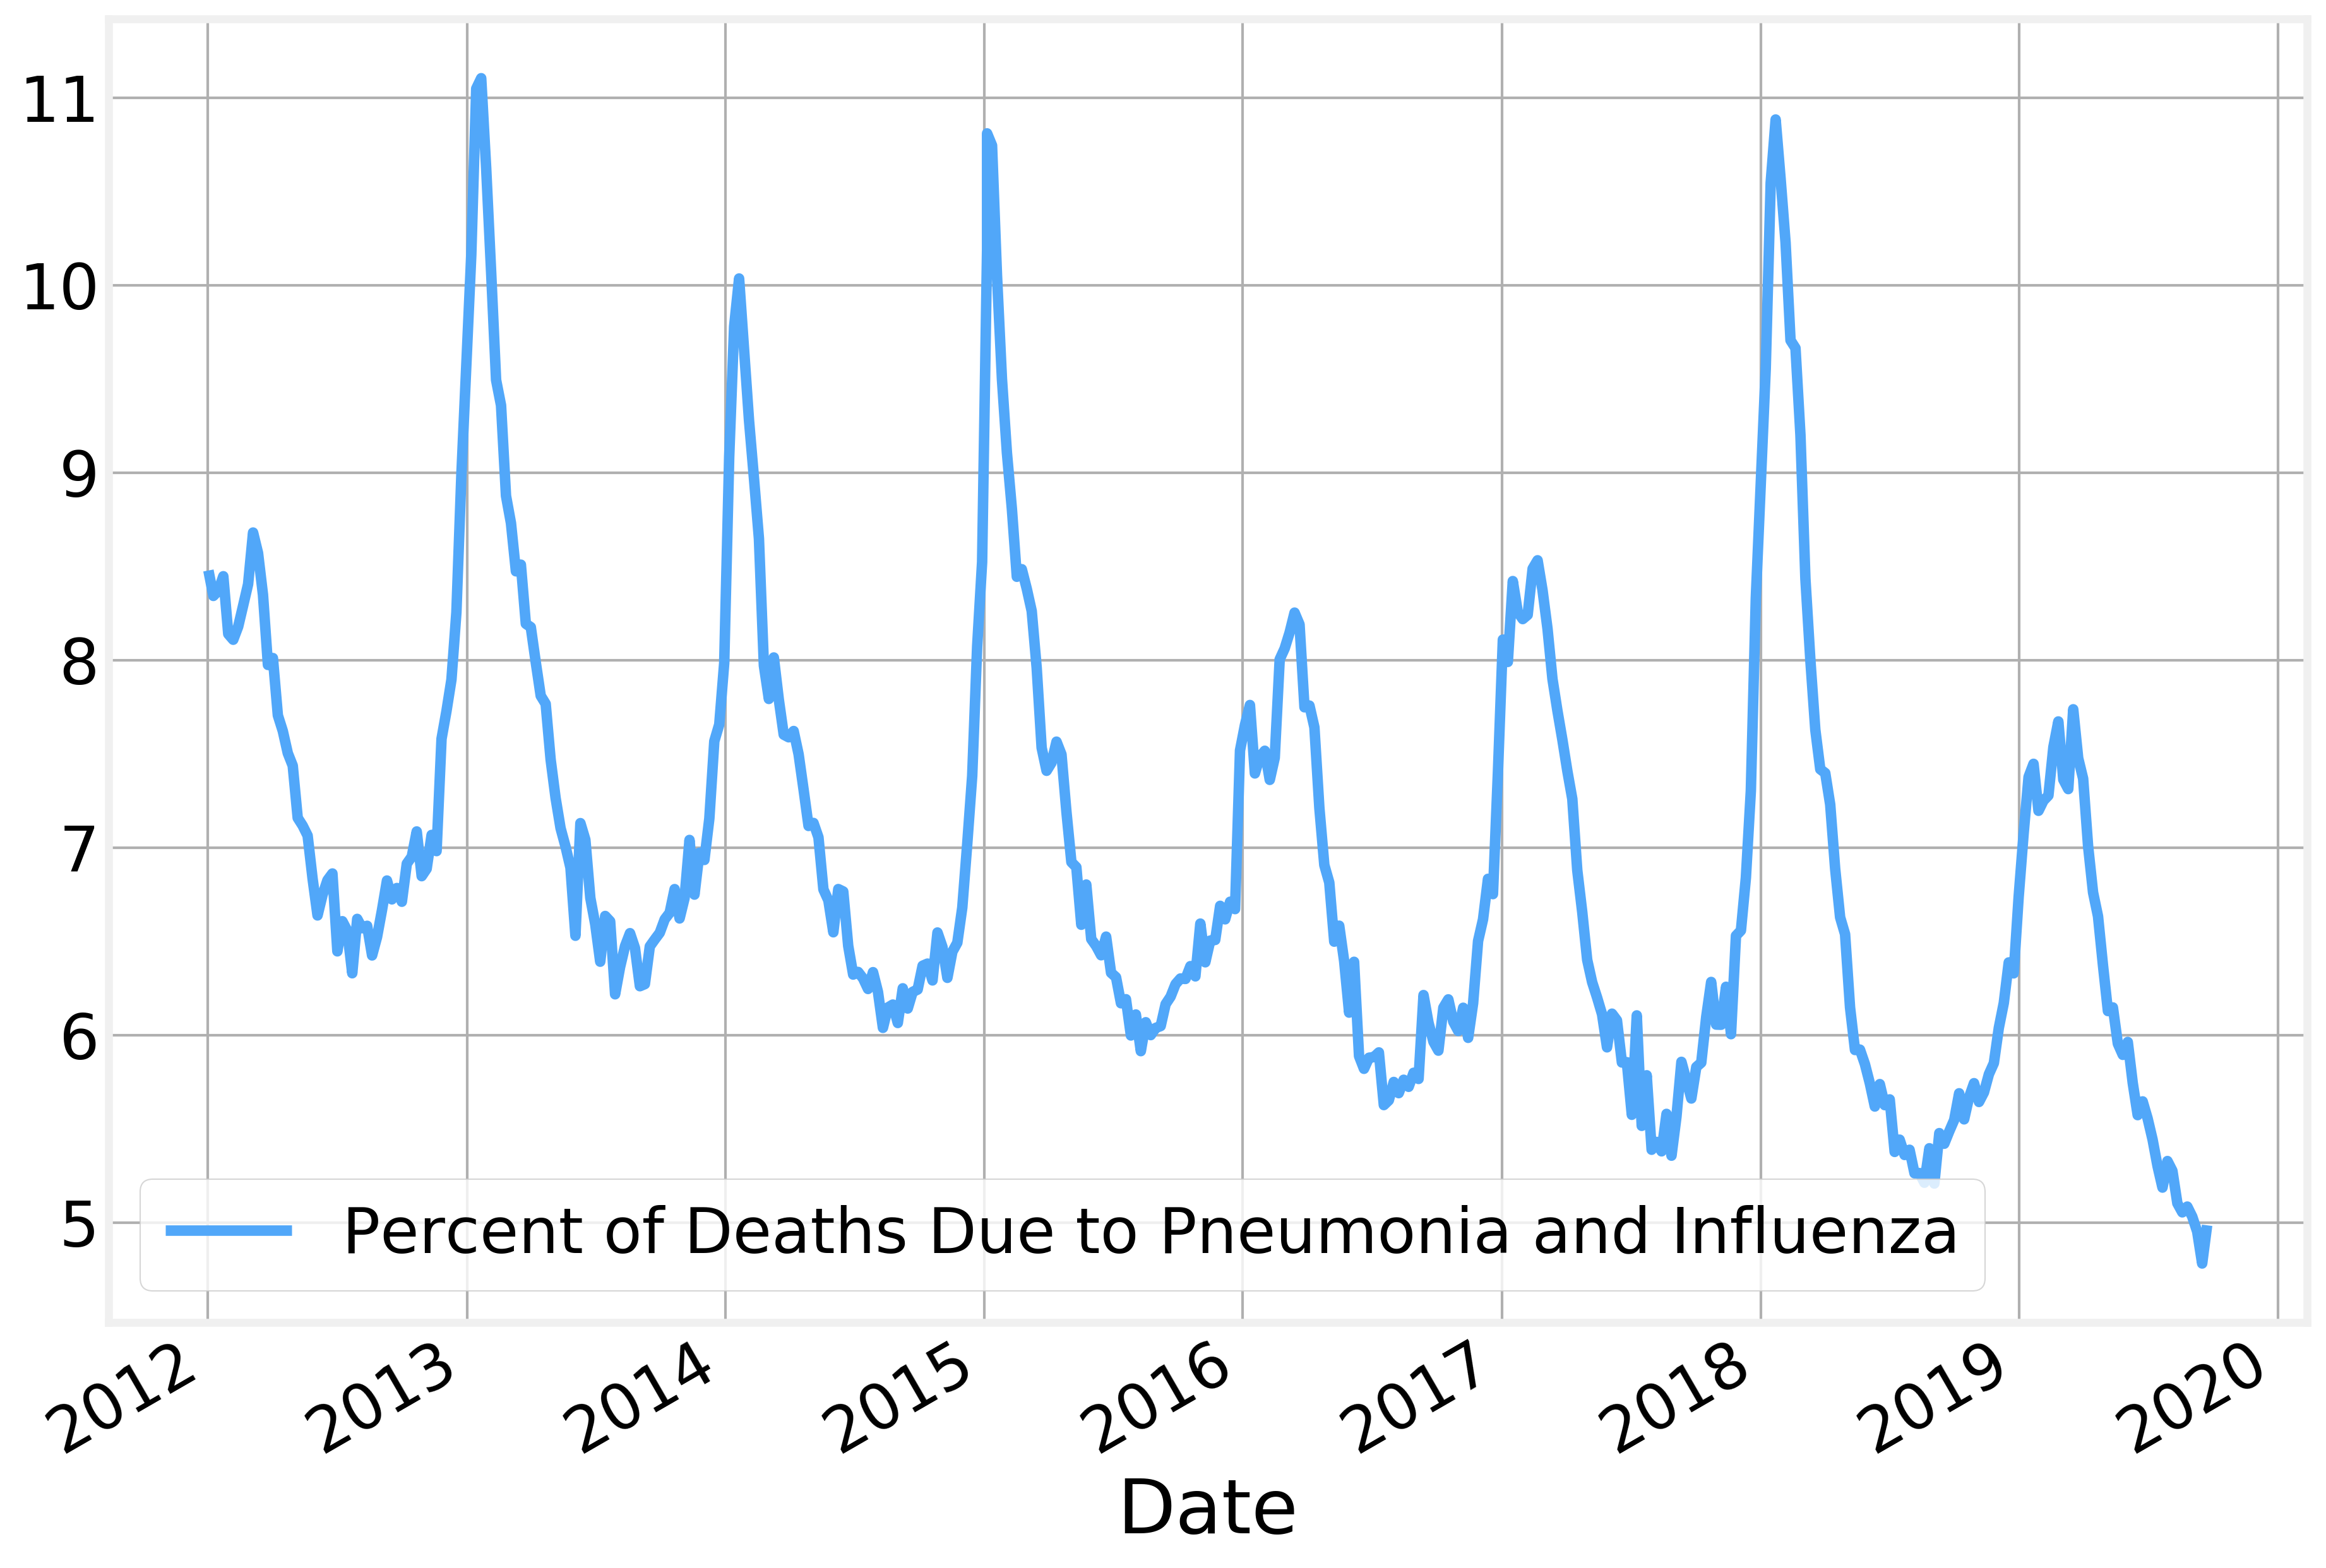

In [7]:
ILI.plot()

We start by performing an Augmented Dickey-Fuller test to confirm that the time series is stationary

In [8]:
adf, pvalue, critical, results = sm.tsa.stattools.adfuller(ILI, regresults=True)

which indeed is confirmed by the p-value

In [9]:
pvalue

0.00016034951684142202

The next step is then to plot the Autocorrelation function

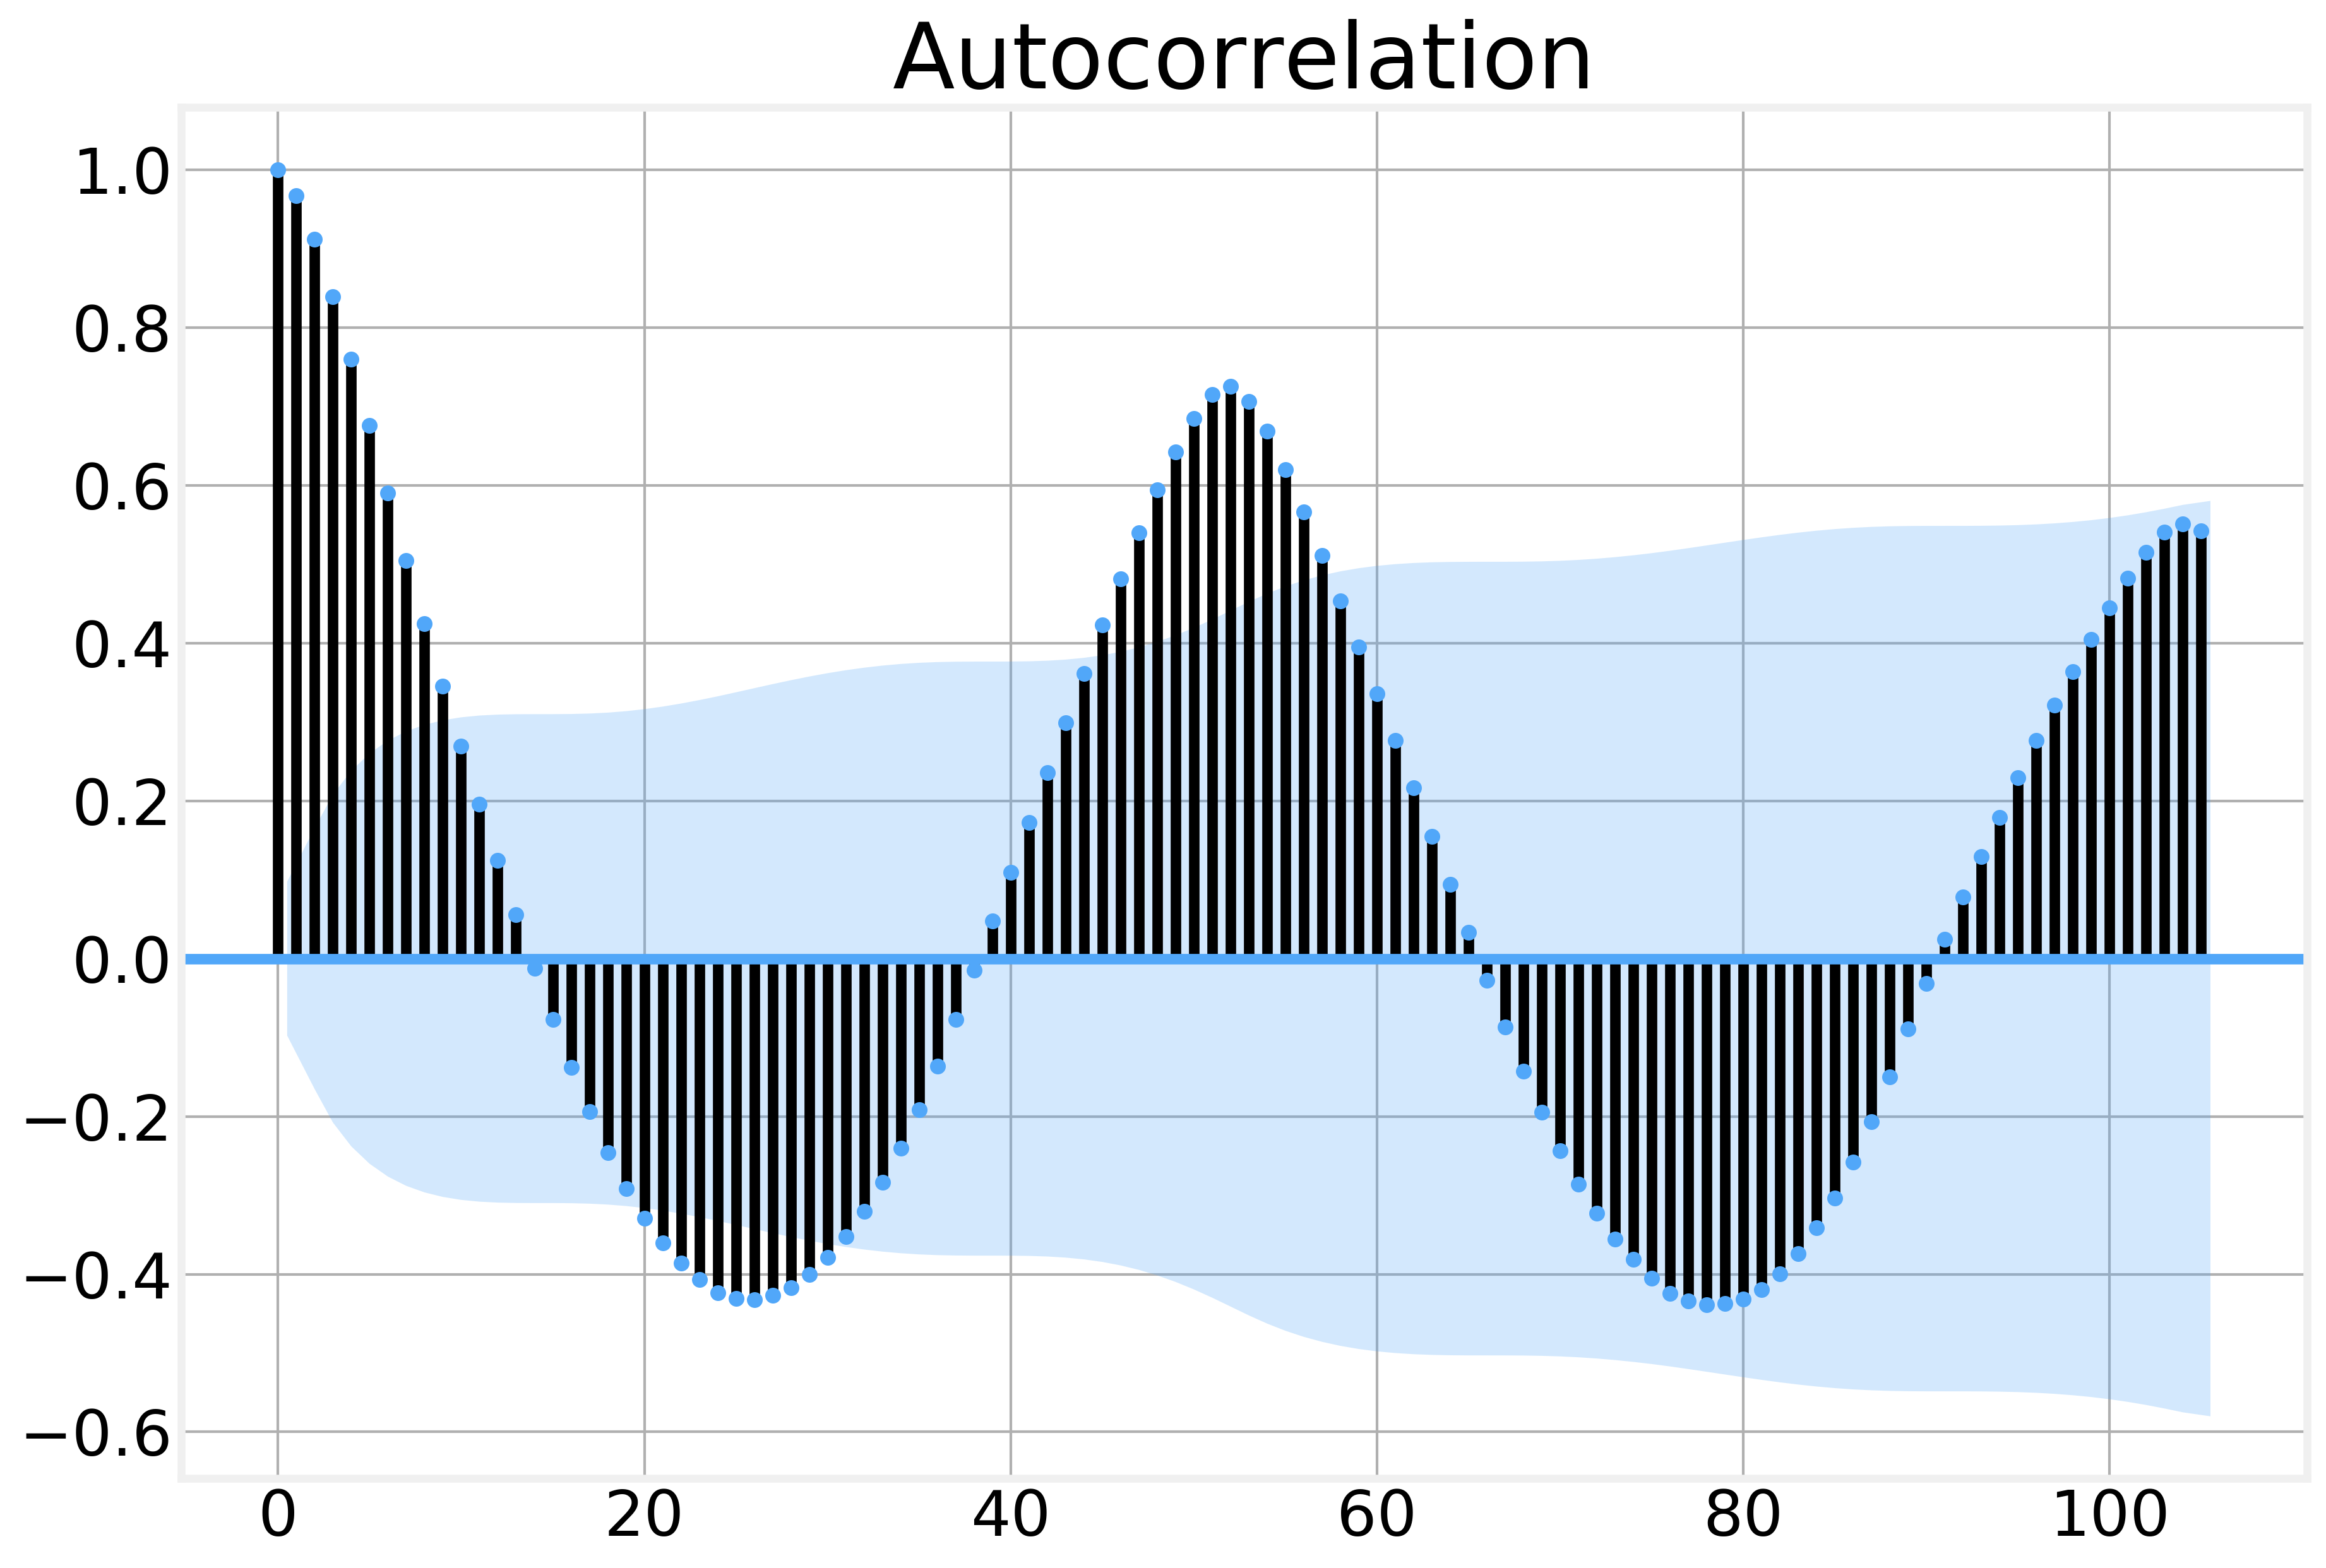

In [10]:
sm.graphics.tsa.plot_acf(ILI, lags=105);

This seems to indicate that the time series is not stationary. Indeed, the oscilating pattern of the ACF is a clue that the have a strong seasonal behavior every 52 weeks. We can (for now) bypass this problem by taking the first difference of the original timeseries

In [11]:
ILI2 = ILI.diff(1).dropna()

Let us visualize the difference dataset

Text(0, 0.5, 'WoW change')

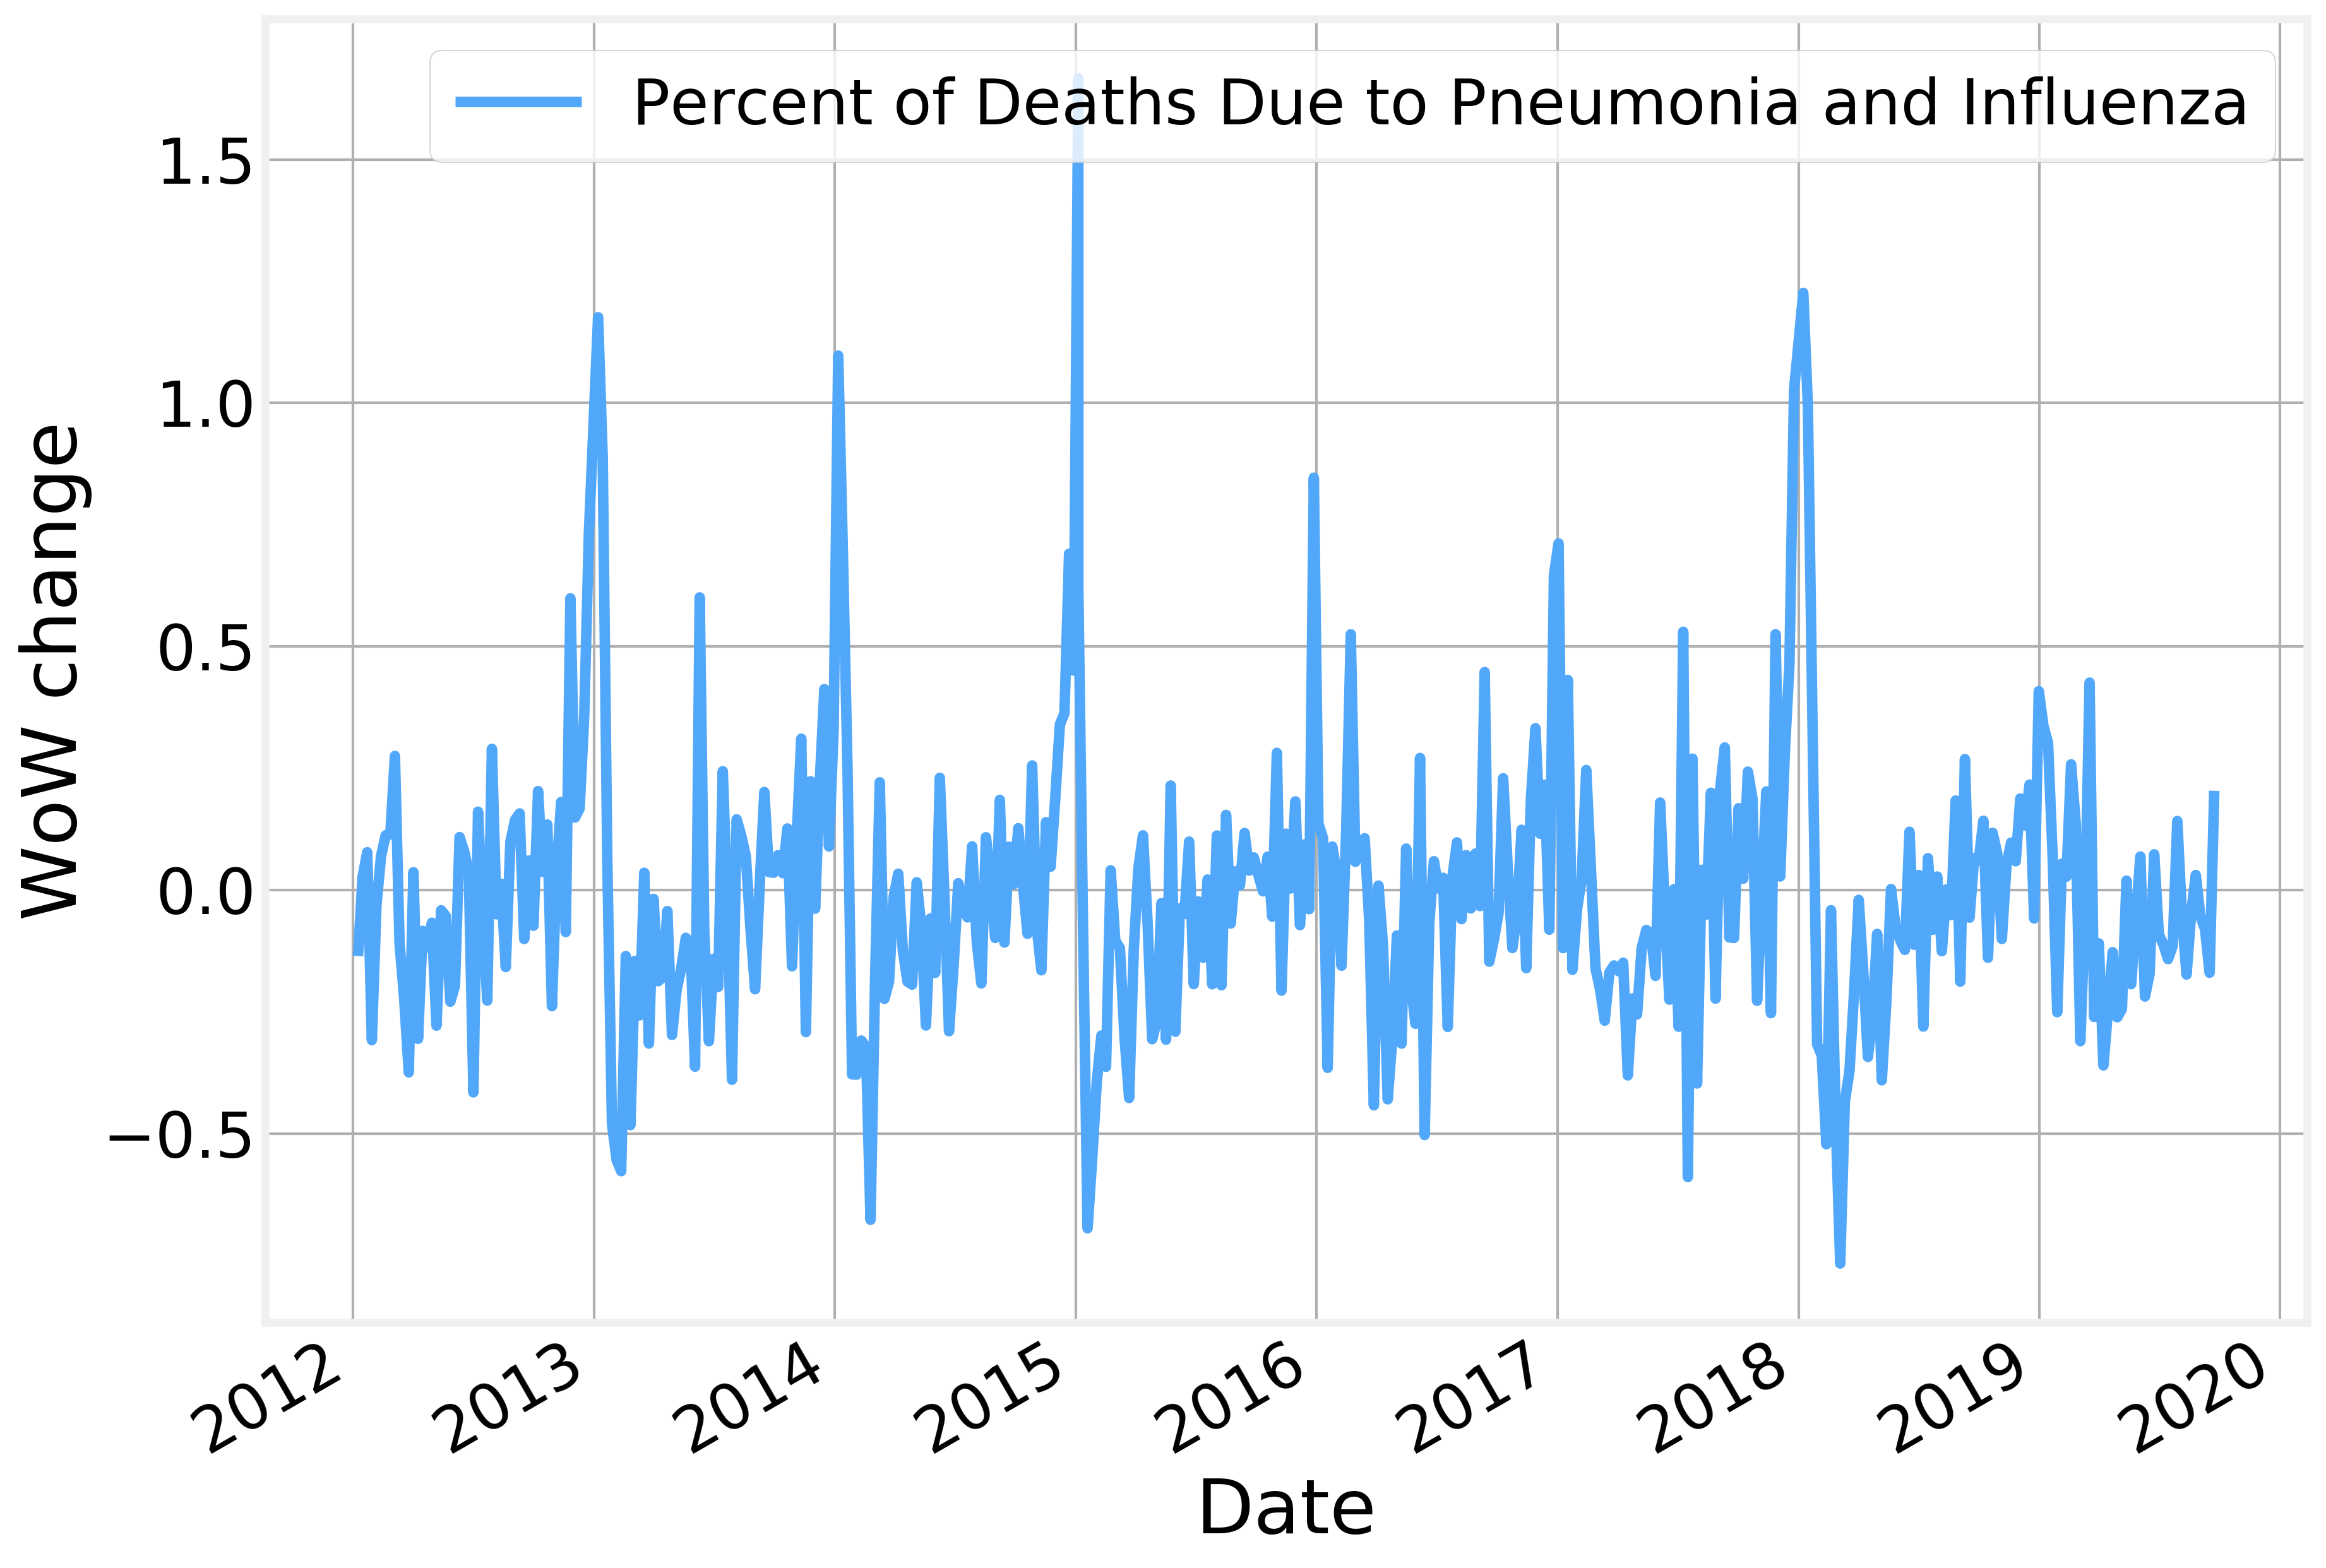

In [12]:
ax = ILI2.plot()
ax.set_ylabel('WoW change')

Now, when we plot the auto-correlation function we find something much more reasonable, with significant lags up to 2

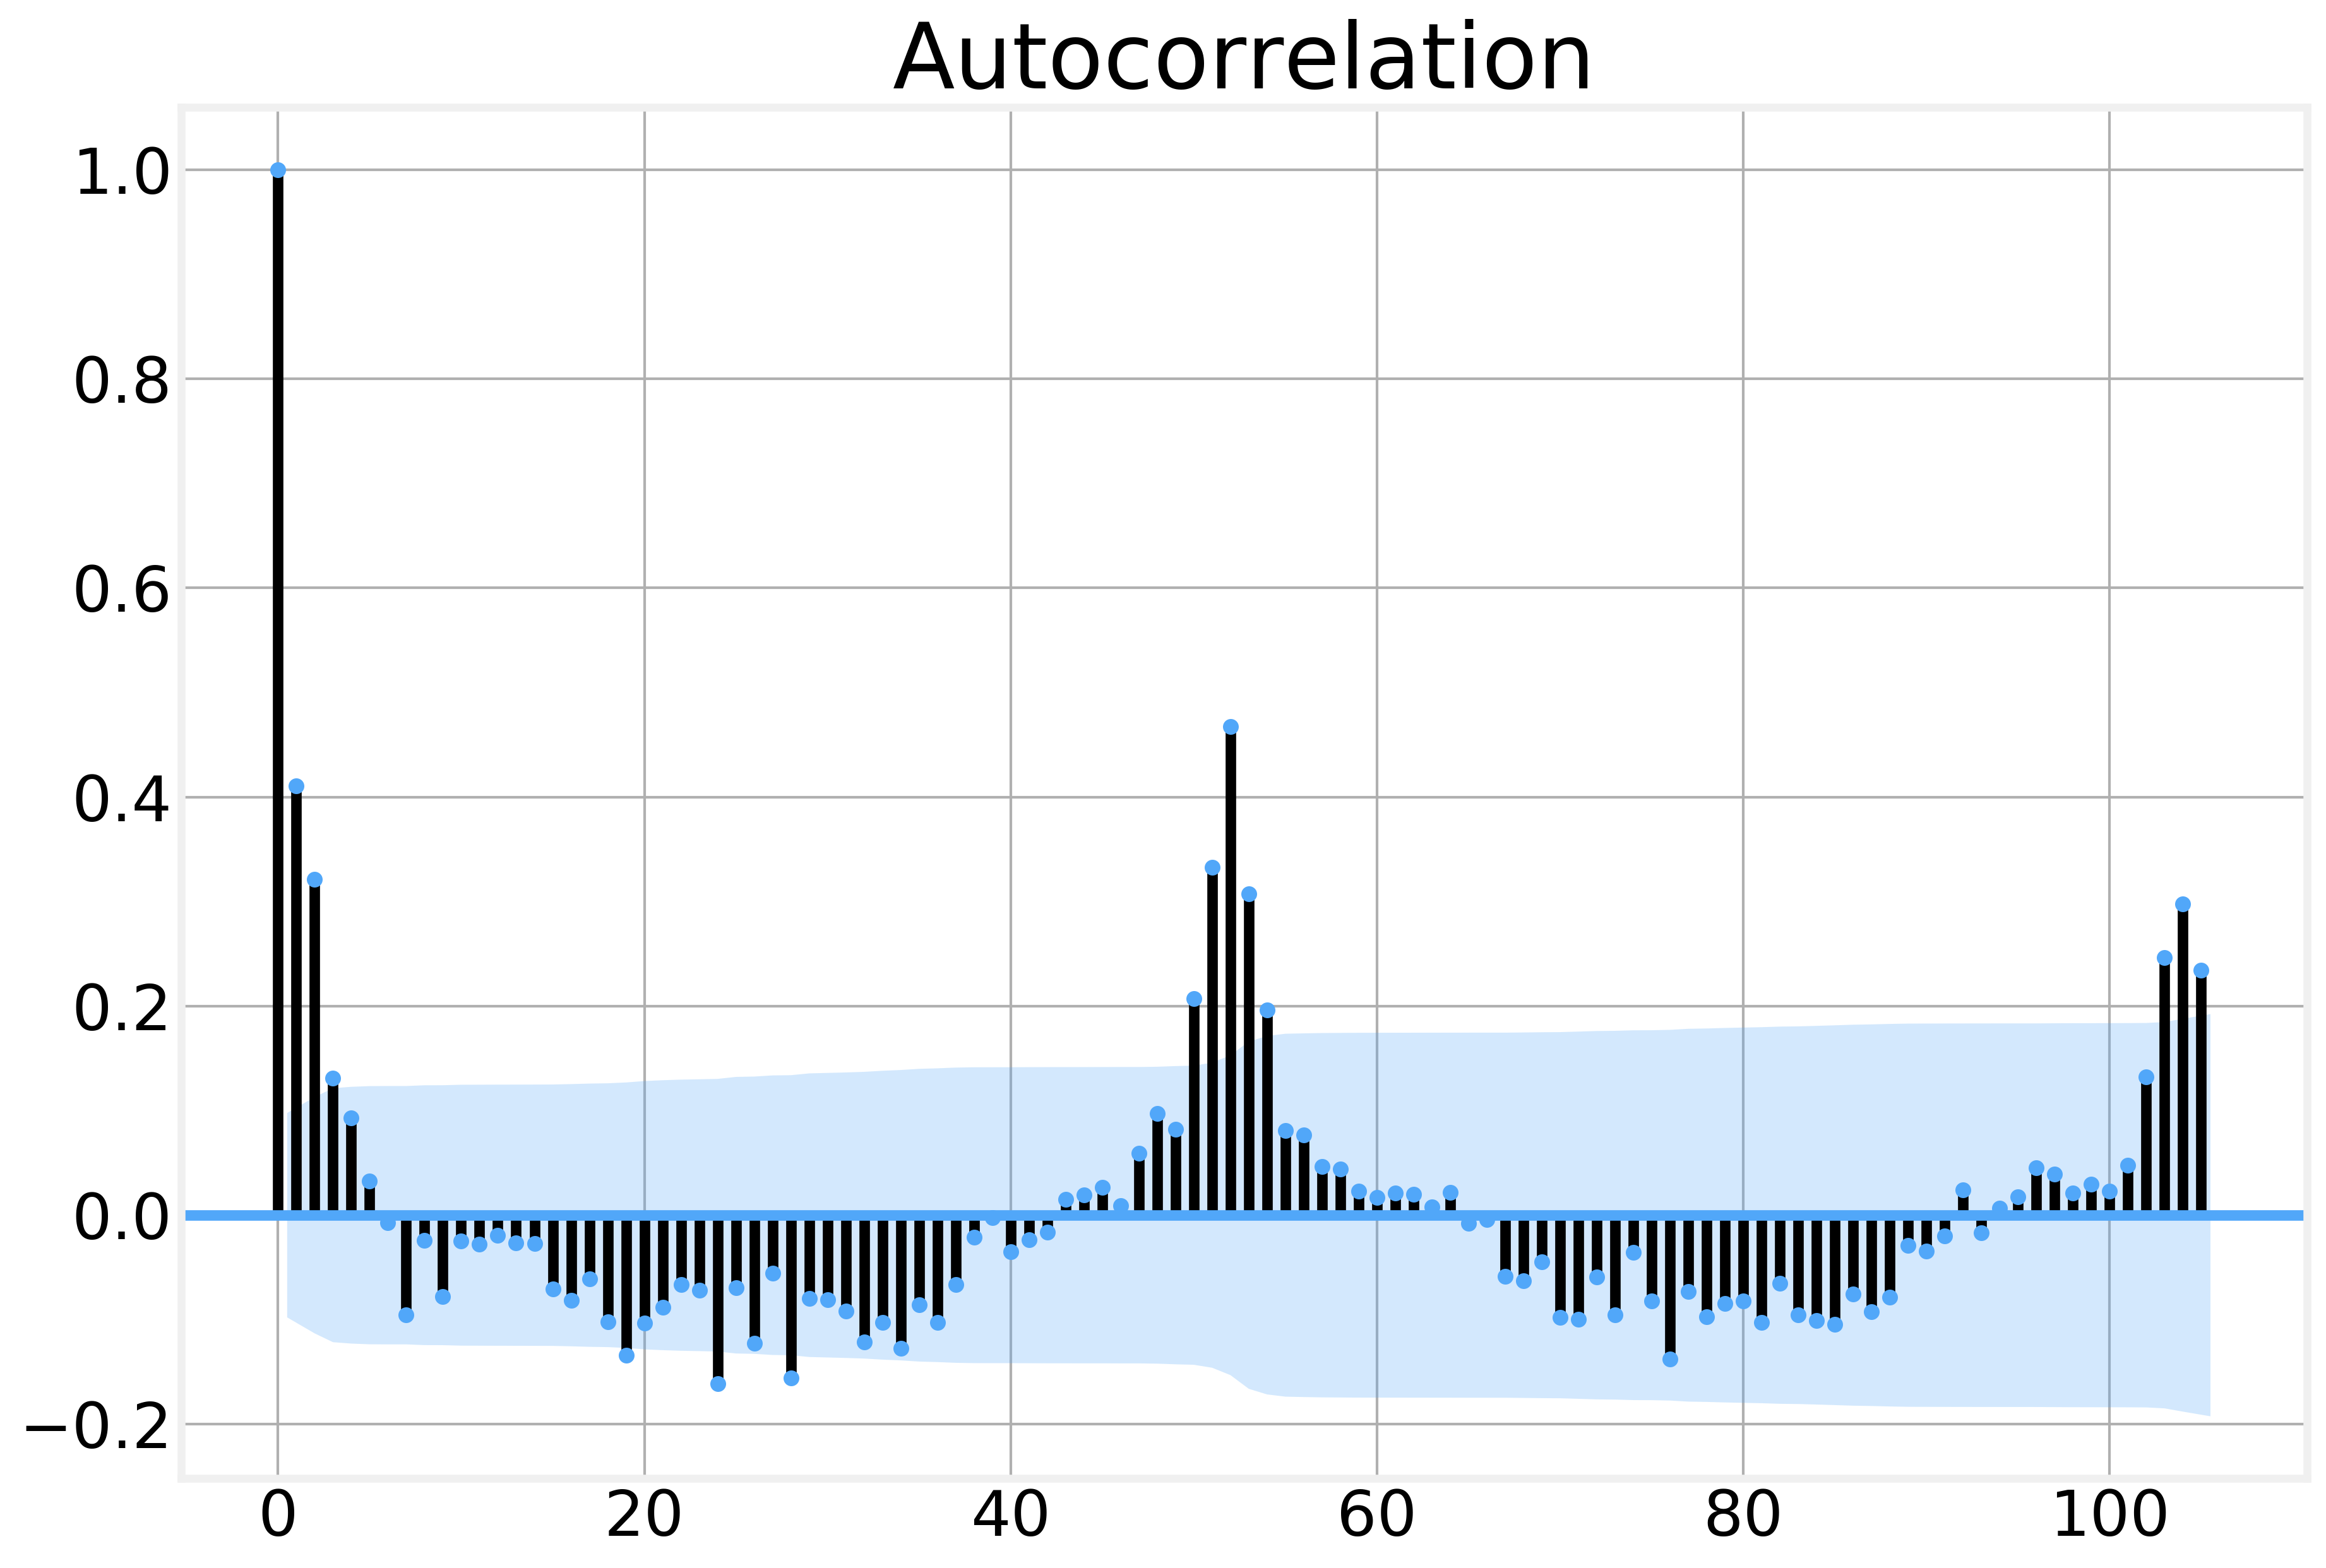

In [13]:
sm.graphics.tsa.plot_acf(ILI2, lags=105);

Although we haven't completely removed the seasonal behavior it is much reduced.

Next we plot the PACF

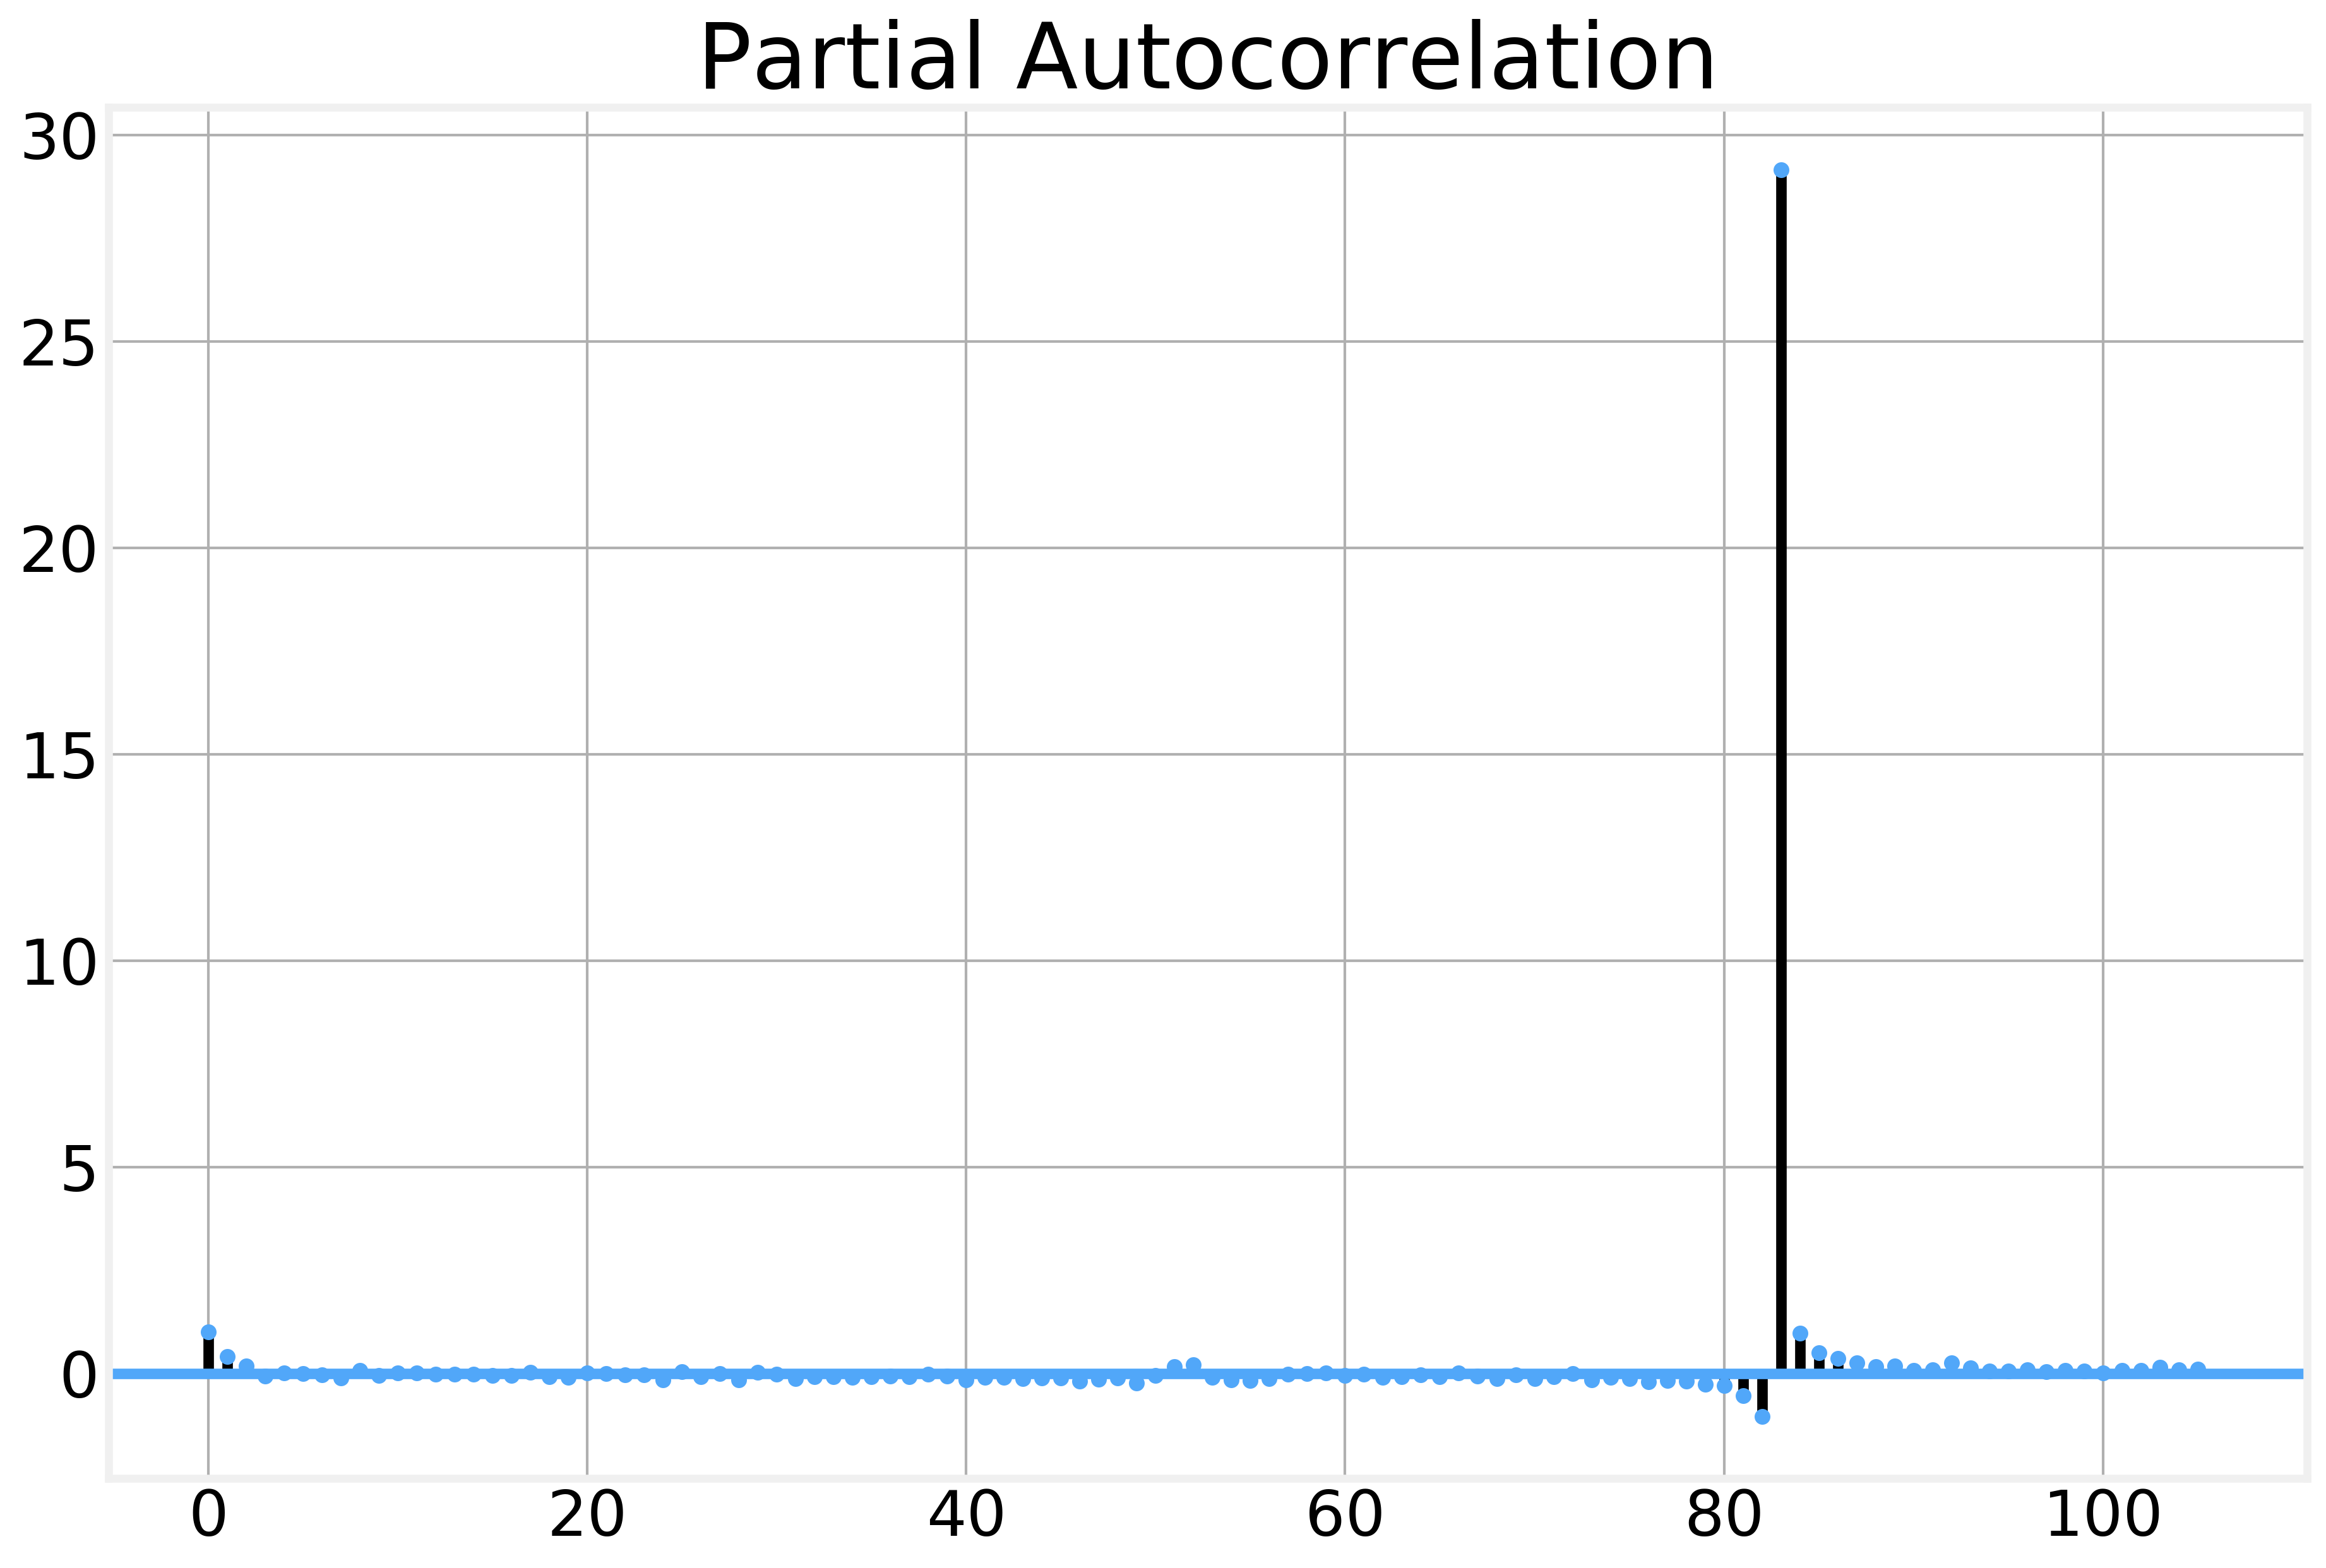

In [14]:
sm.graphics.tsa.plot_pacf(ILI2, lags=105);

And again find two significant lags

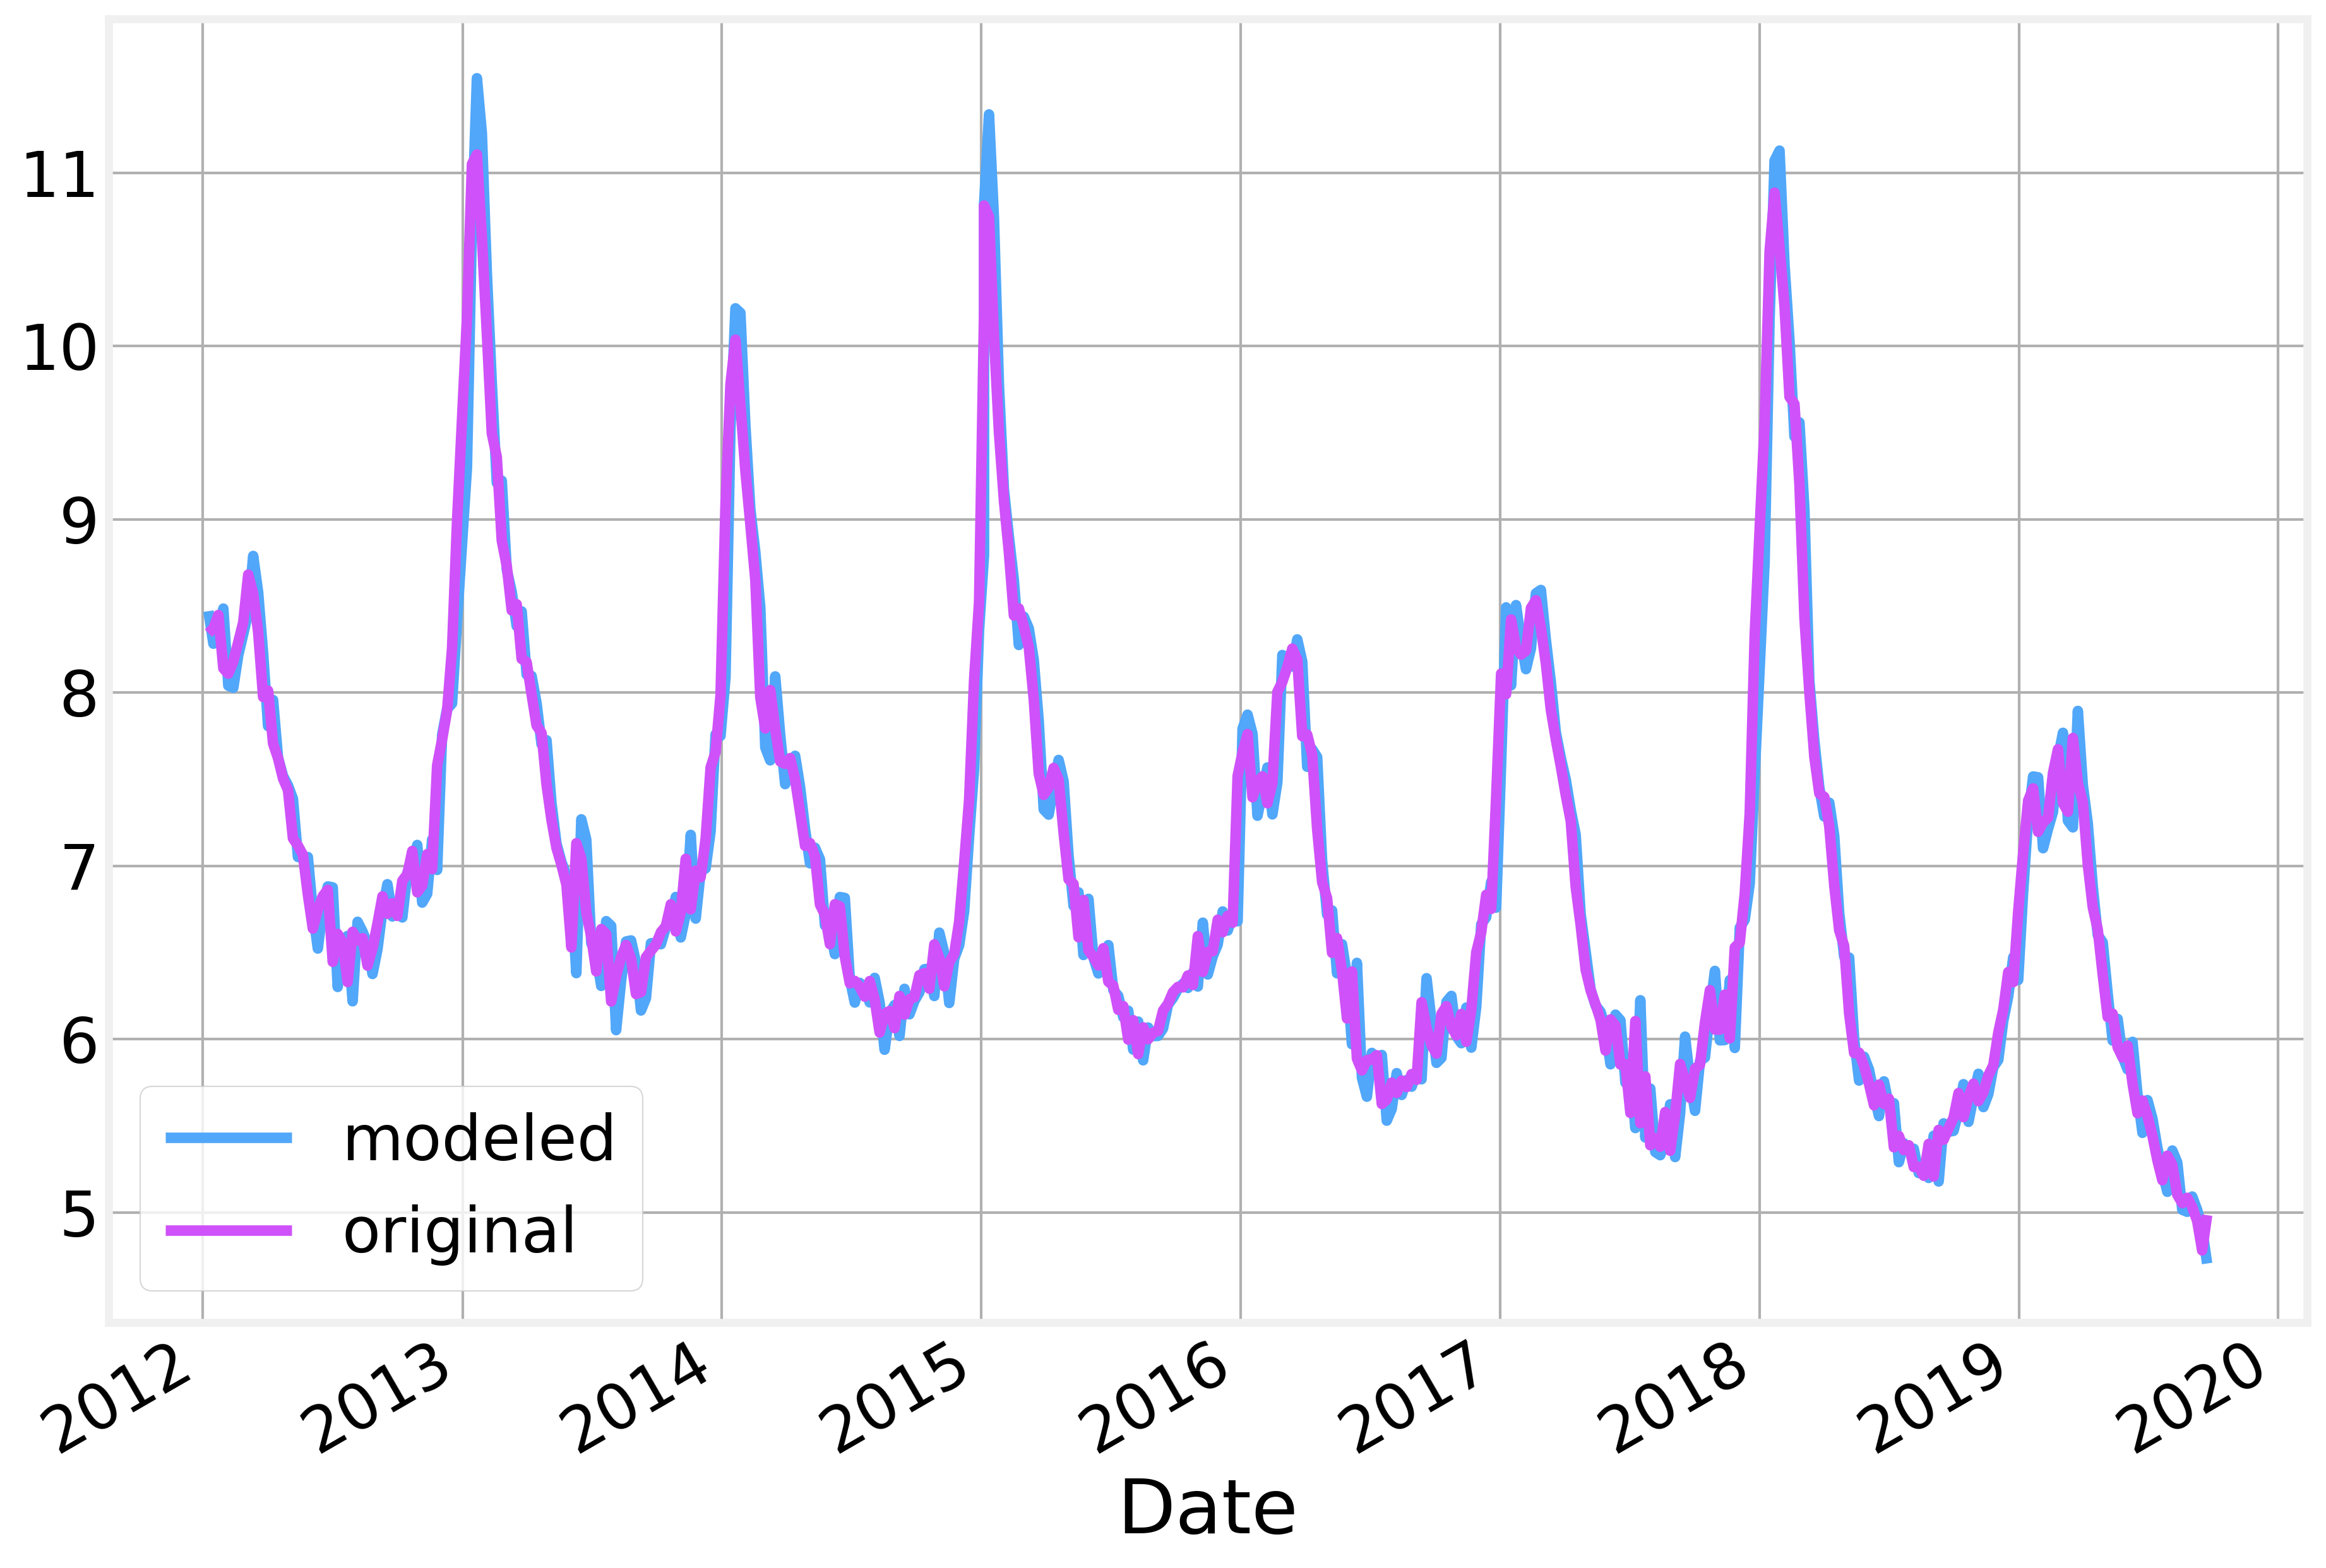

In [15]:
model = sm.tsa.ARIMA(ILI, (2, 1, 2))
results = model.fit()

fig, ax = plt.subplots(1, 1)
pred_sm = results.plot_predict(ax=ax)
plt.legend(['modeled', 'original'])

In [16]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                             ARIMA Model Results                                              
==============================================================================================================
Dep. Variable:     D.Percent of Deaths Due to Pneumonia and Influenza   No. Observations:                  402
Model:                                                 ARIMA(2, 1, 2)   Log Likelihood                 -18.777
Method:                                                       css-mle   S.D. of innovations              0.253
Date:                                                Wed, 12 Aug 2020   AIC                             49.553
Time:                                                        07:41:01   BIC                             73.532
Sample:                                                             1   HQIC                            59.047
                                                                                                              
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       -0.0086      0.025     -0.346      0.729      -0.057       0.040
ar.L1.D.Percent of Deaths Due to Pneumonia and Influenza     0.0506      0.561      0.090      0.928      -1.050       1.151
ar.L2.D.Percent of Deaths Due to Pneumonia and Influenza     0.2785      0.476      0.585      0.559      -0.655       1.212
ma.L1.D.Percent of Deaths Due to Pneumonia and Influenza     0.2971      0.564      0.527      0.598      -0.808       1.403
ma.L2.D.Percent of Deaths Due to Pneumonia and Influenza     0.0261      0.318      0.082      0.935      -0.597       0.649
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8061           +0.0000j            1.8061            0.0000
AR.2           -1.9878           +0.0000j            1.9878            0.5000
MA.1           -5.7000           -2.4260j            6.1948           -0.4360
MA.2           -5.7000           +2.4260j            6.1948            0.4360
-----------------------------------------------------------------------------
"""

(4, 12)

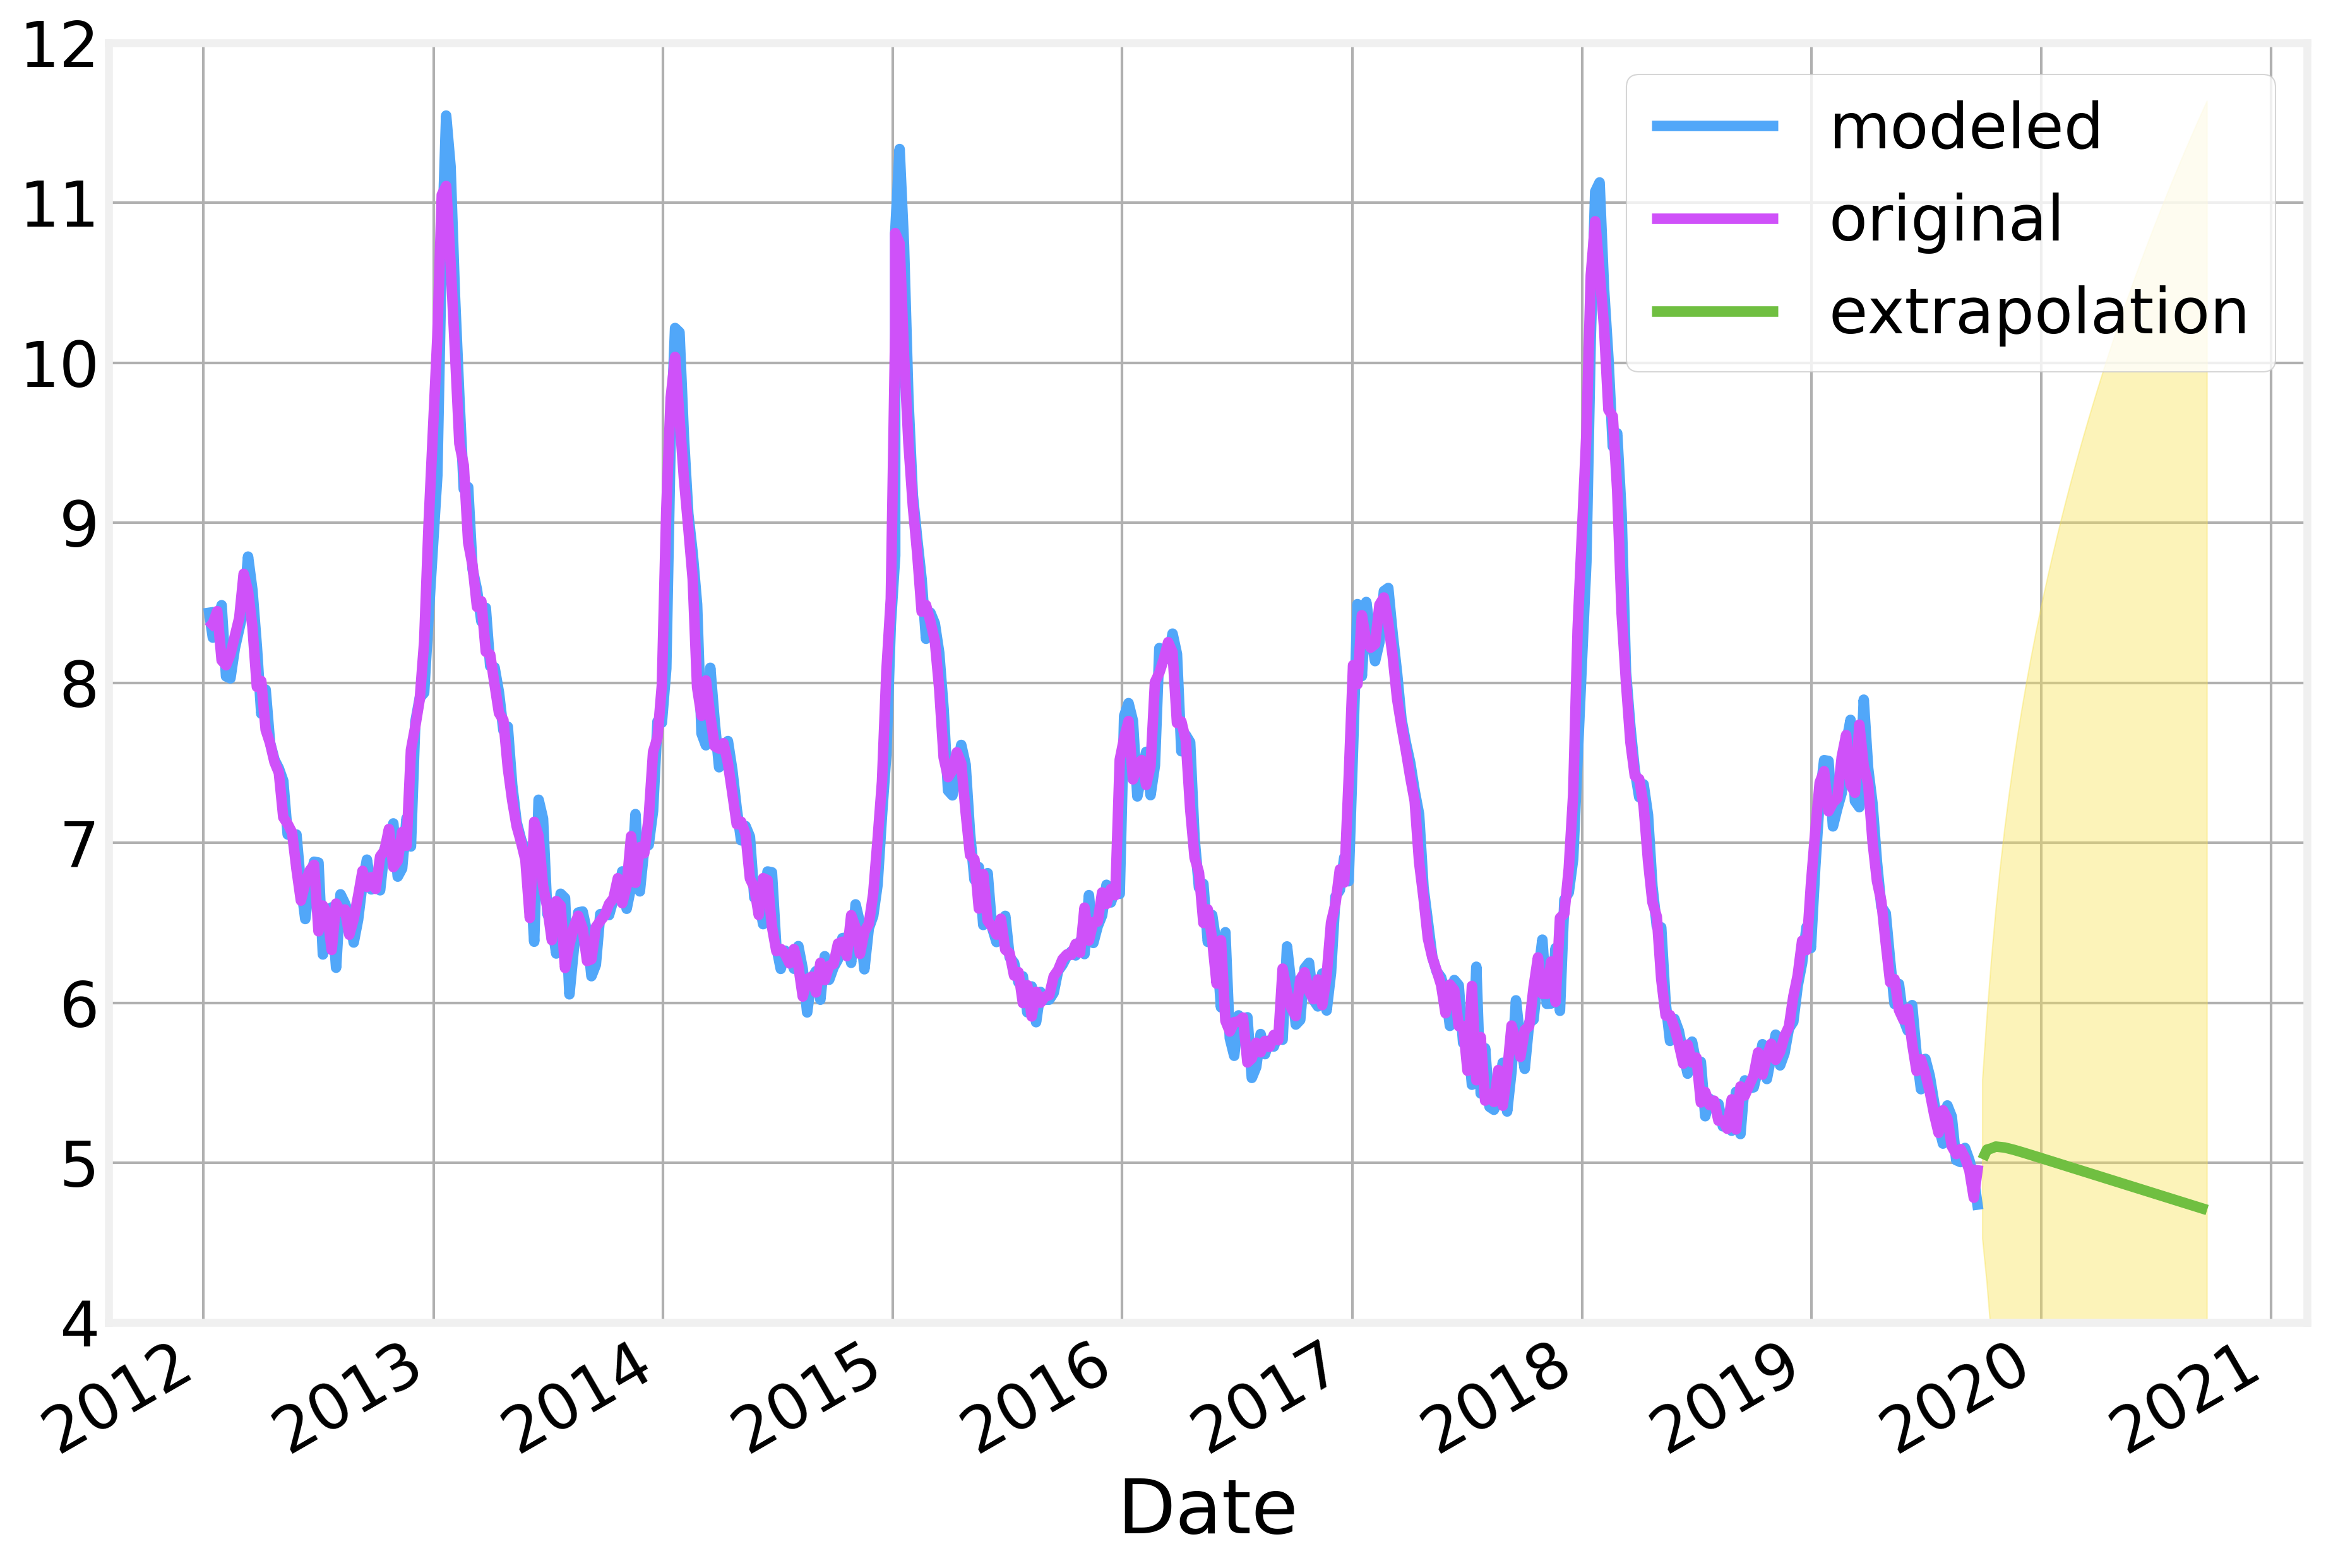

In [17]:
model = sm.tsa.ARIMA(ILI, order=(2, 1, 2))
results = model.fit()

fig, ax = plt.subplots(1, 1)
results.plot_predict(ax=ax);

new_weeks = ILI.index[-1]+pd.timedelta_range('7 day', periods=52, freq='7d')
forecast = results.forecast(steps=52)
ax.plot(new_weeks, forecast[0])
ax.fill_between(new_weeks, forecast[2].T[0], forecast[2].T[1], alpha=0.4, color=colors[4])

ax.legend(['modeled', 'original', 'extrapolation'])
ax.set_ylim(4, 12)

In [18]:
seasonal_ILI = ILI.diff(52).diff(1).dropna().copy()

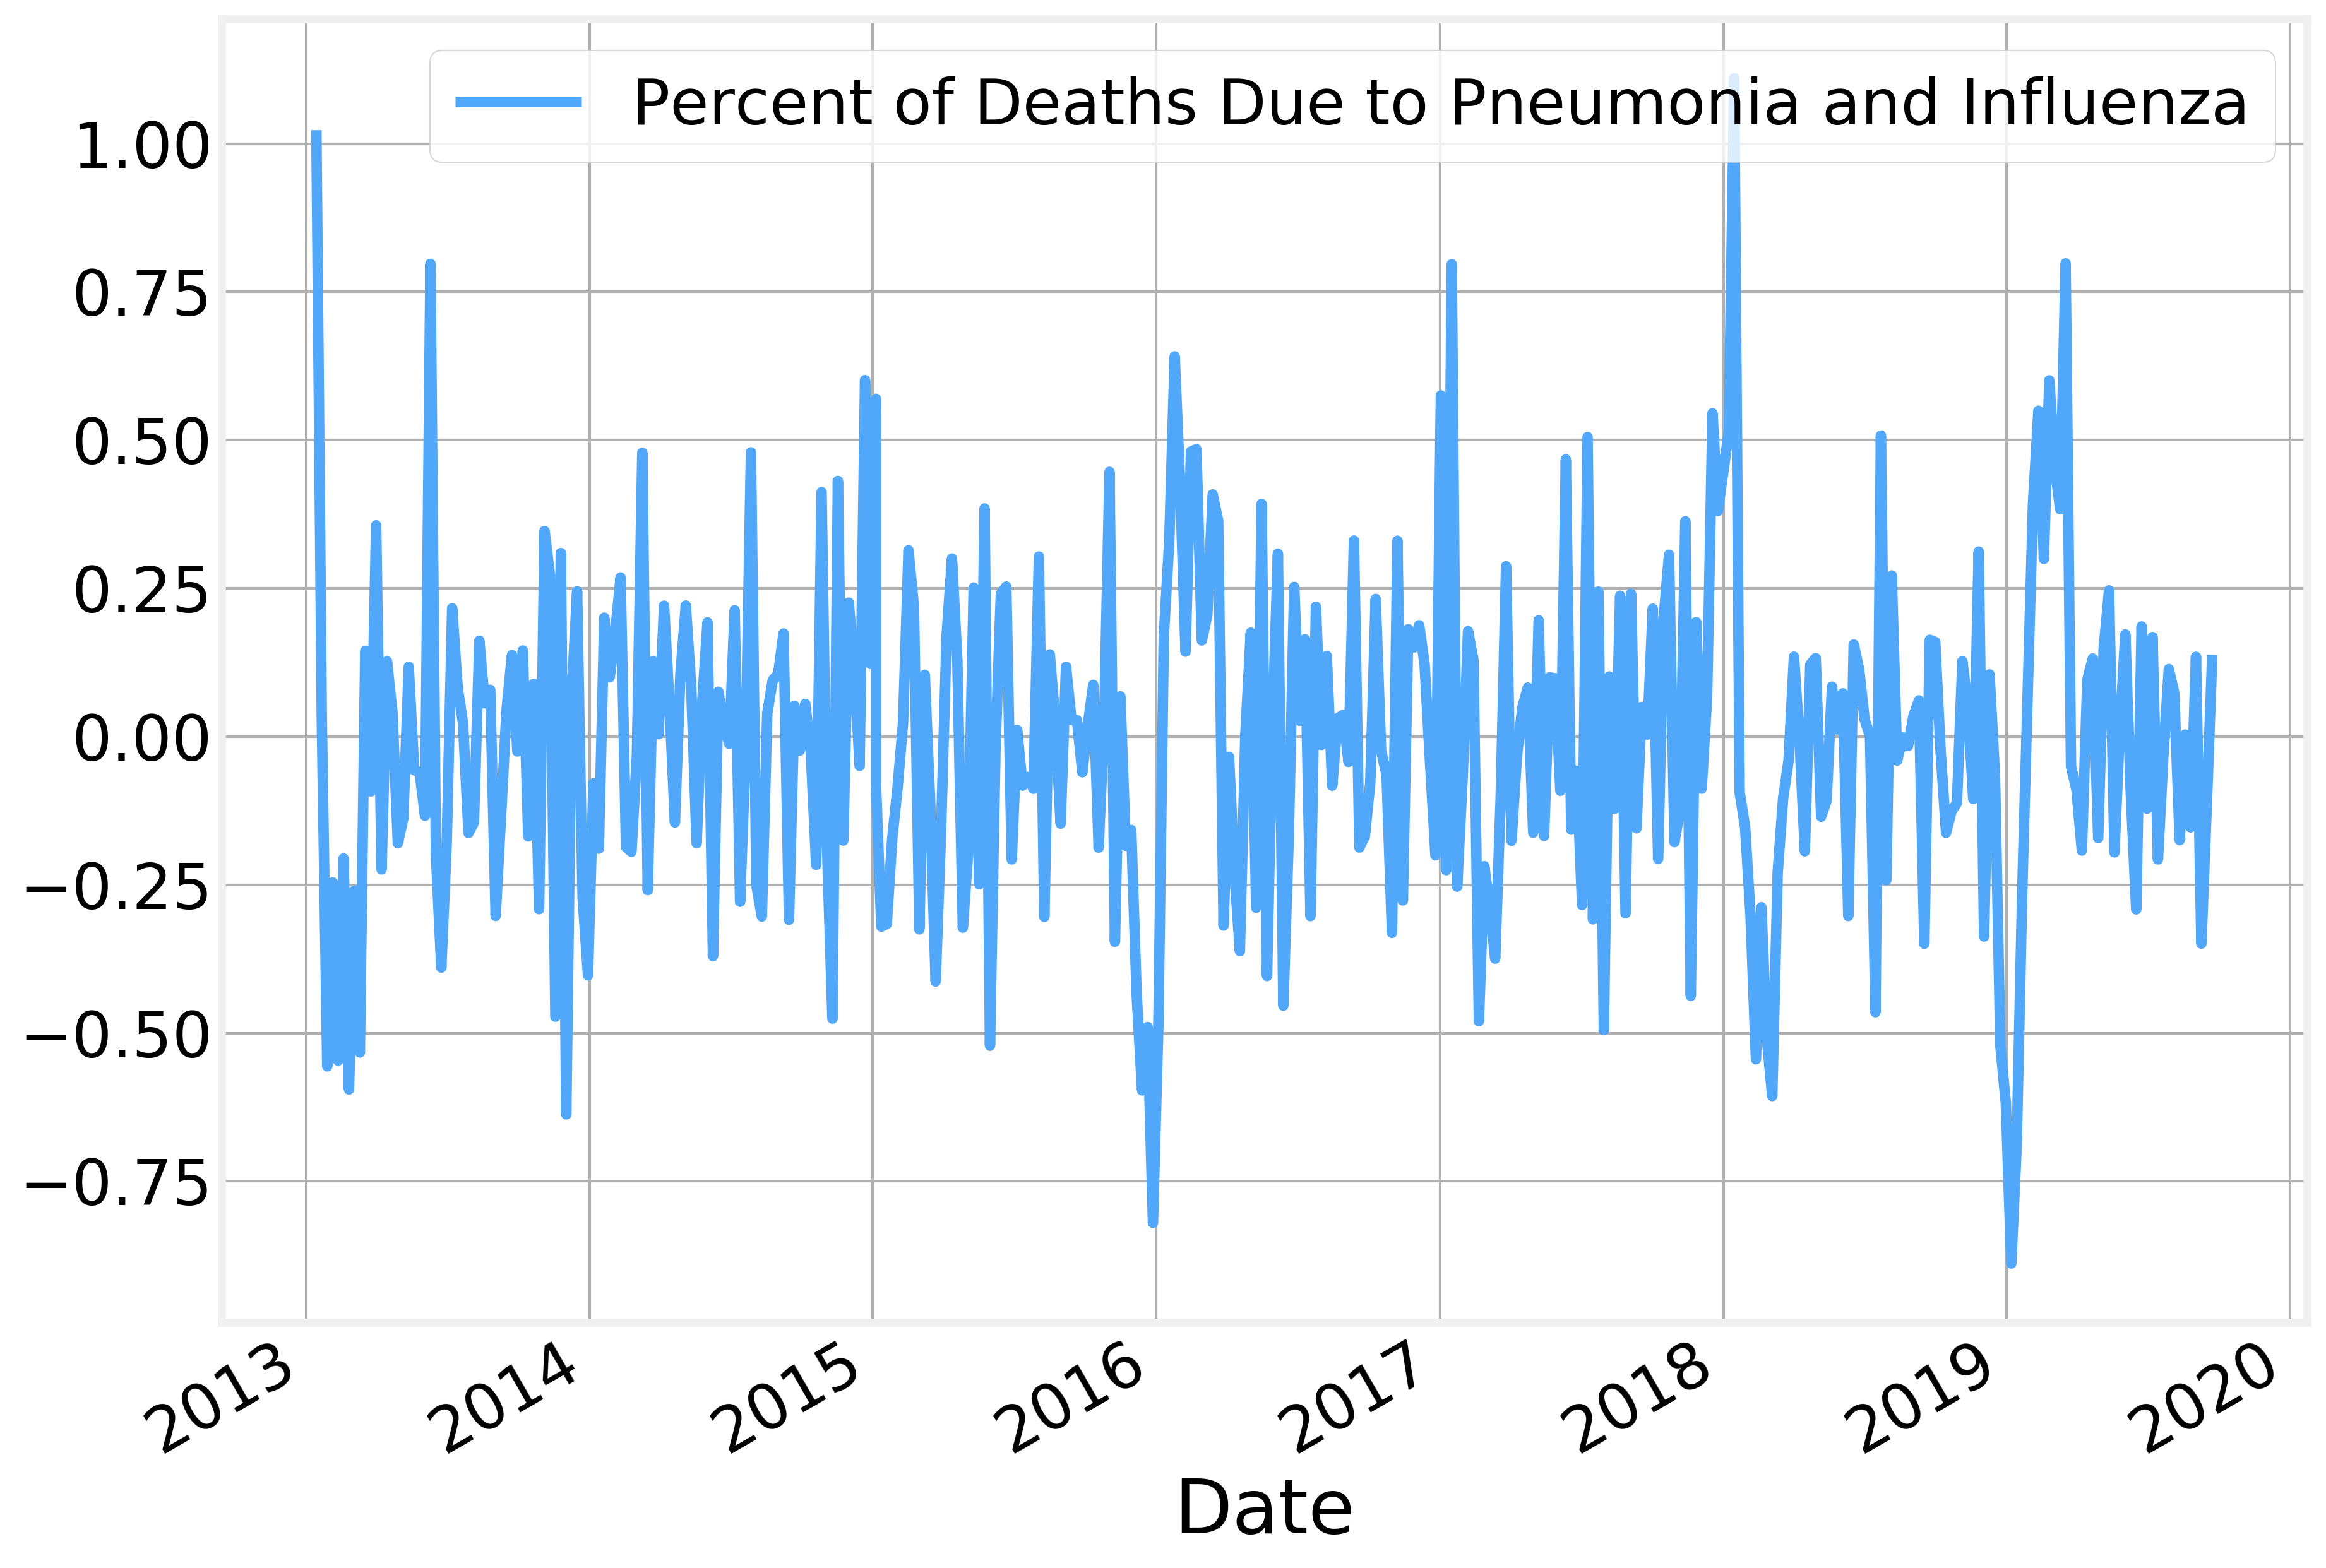

In [19]:
seasonal_ILI.plot()

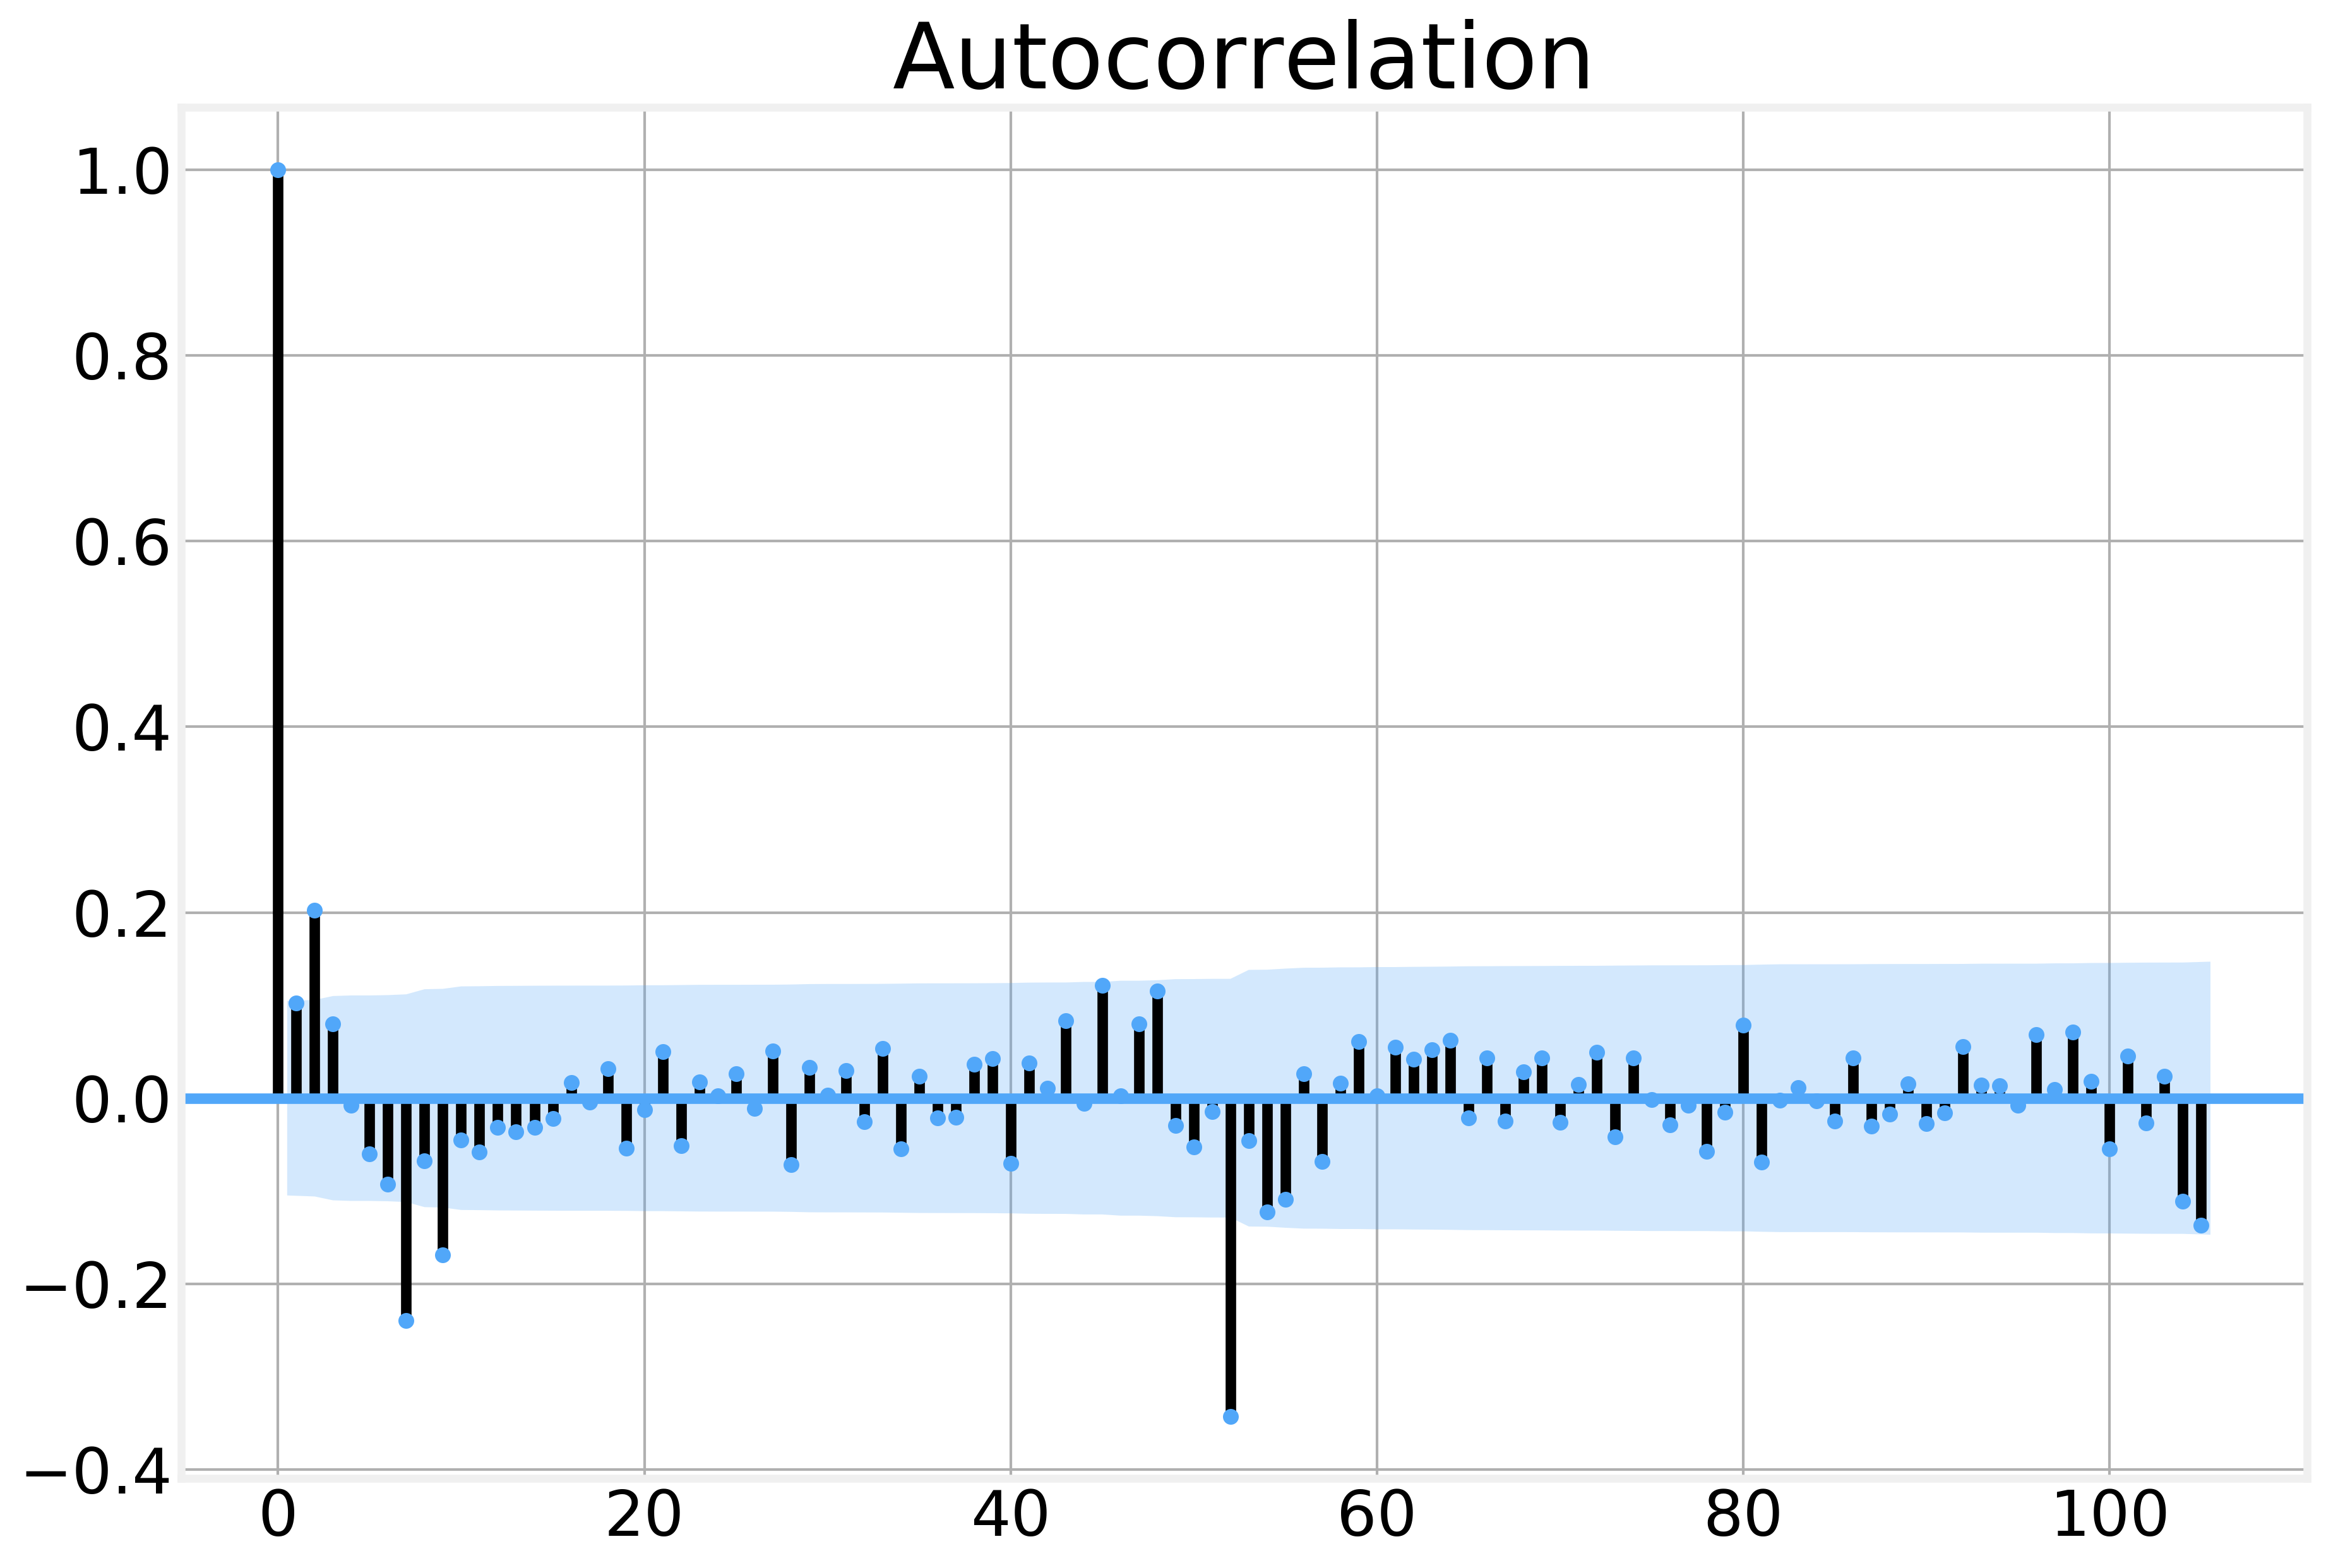

In [20]:
sm.graphics.tsa.plot_acf(seasonal_ILI, lags=105);

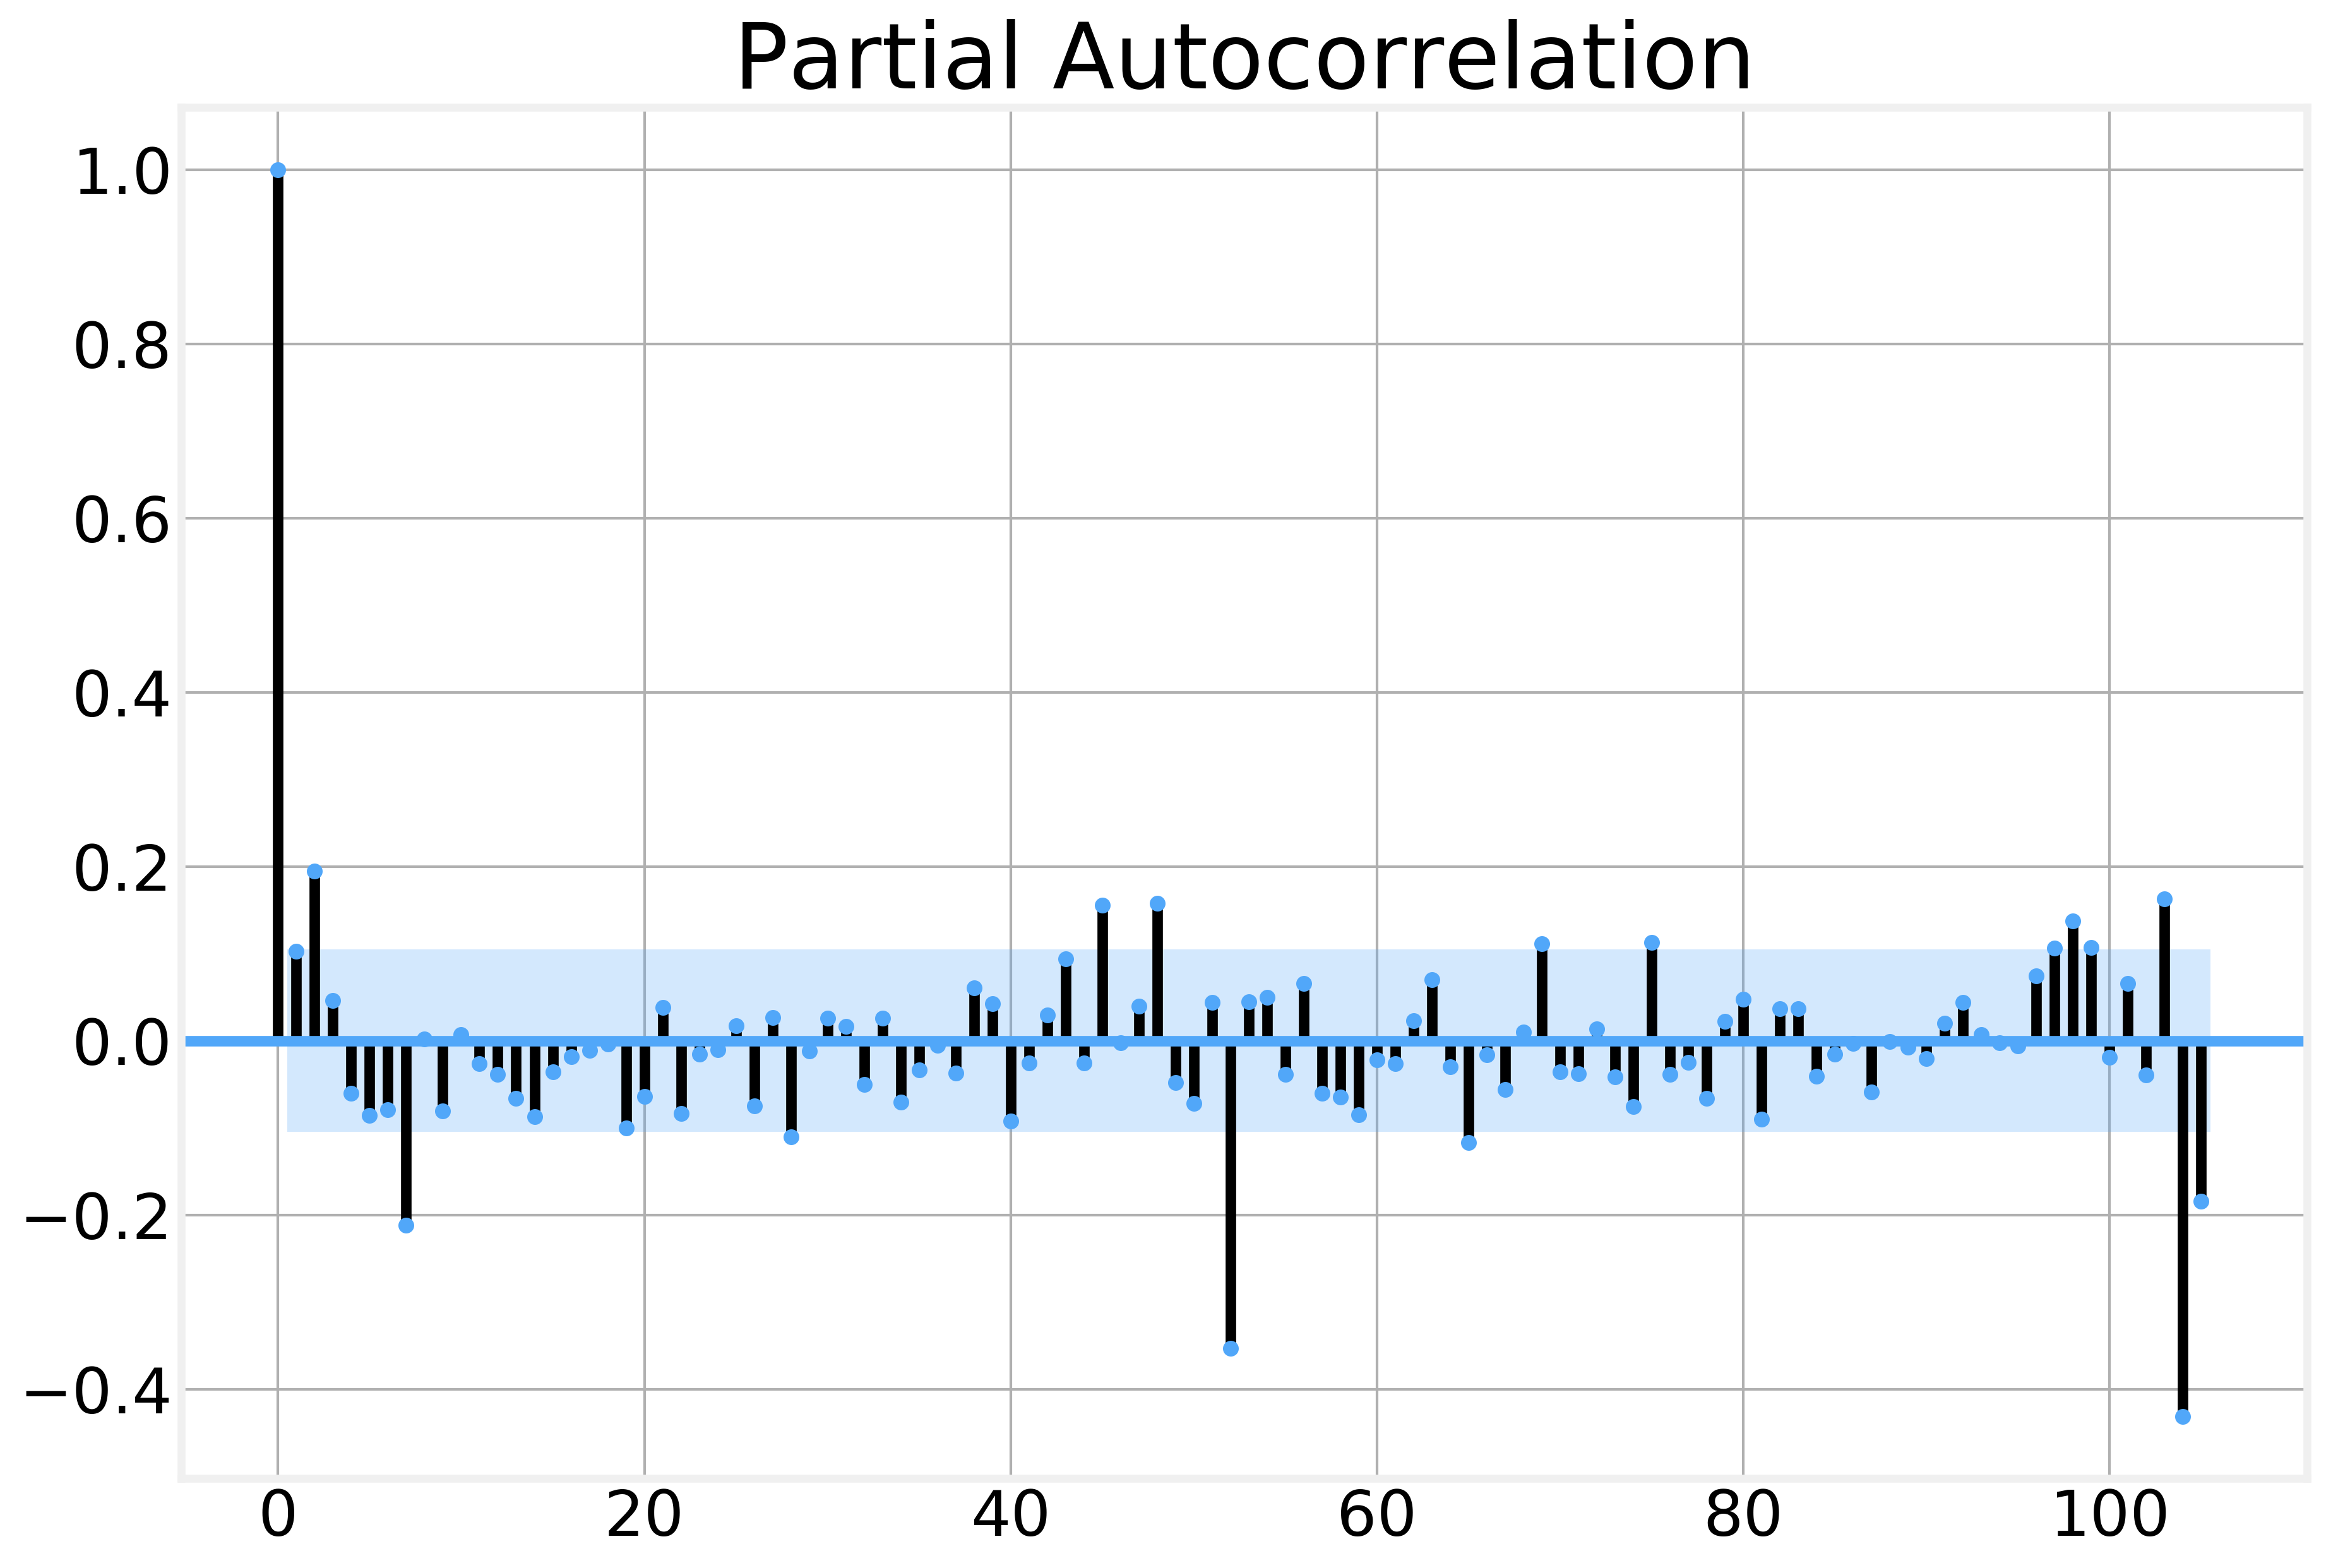

In [21]:
sm.graphics.tsa.plot_pacf(seasonal_ILI, lags=105);

In [22]:
mod = sm.tsa.statespace.SARIMAX(ILI.values,
                                order=(2, 1, 2),
                                seasonal_order=(1, 1, 1, 52),
                                simple_differencing=False)

In [23]:
res = mod.fit()

In [24]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  403
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood                   3.377
Date:                              Wed, 12 Aug 2020   AIC                              7.246
Time:                                      07:43:38   BIC                             34.252
Sample:                                           0   HQIC                            17.995
                                              - 403                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4373      0.142     10.140      0.000       1.159       1.715
ar.L2         -0.7695      0.120     -6.422      0.000      -1.004      -0.535
ma.L1         -1.3408      0.140     -9.574      0.000      -1.615      -1.066
ma.L2          0.7648      0.109      7.030      0.000       0.552       0.978
ar.S.L52       0.1716      0.094      1.827      0.068      -0.012       0.356
ma.S.L52      -0.9979     11.242     -0.089      0.929     -23.033      21.037
sigma2         0.0443      0.495      0.090      0.929      -0.926       1.015
===================================================================================
Ljung-Box (Q):                       40.94   Jarque-Bera (JB):                38.34
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.47
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

And we can visualize our extrapolation

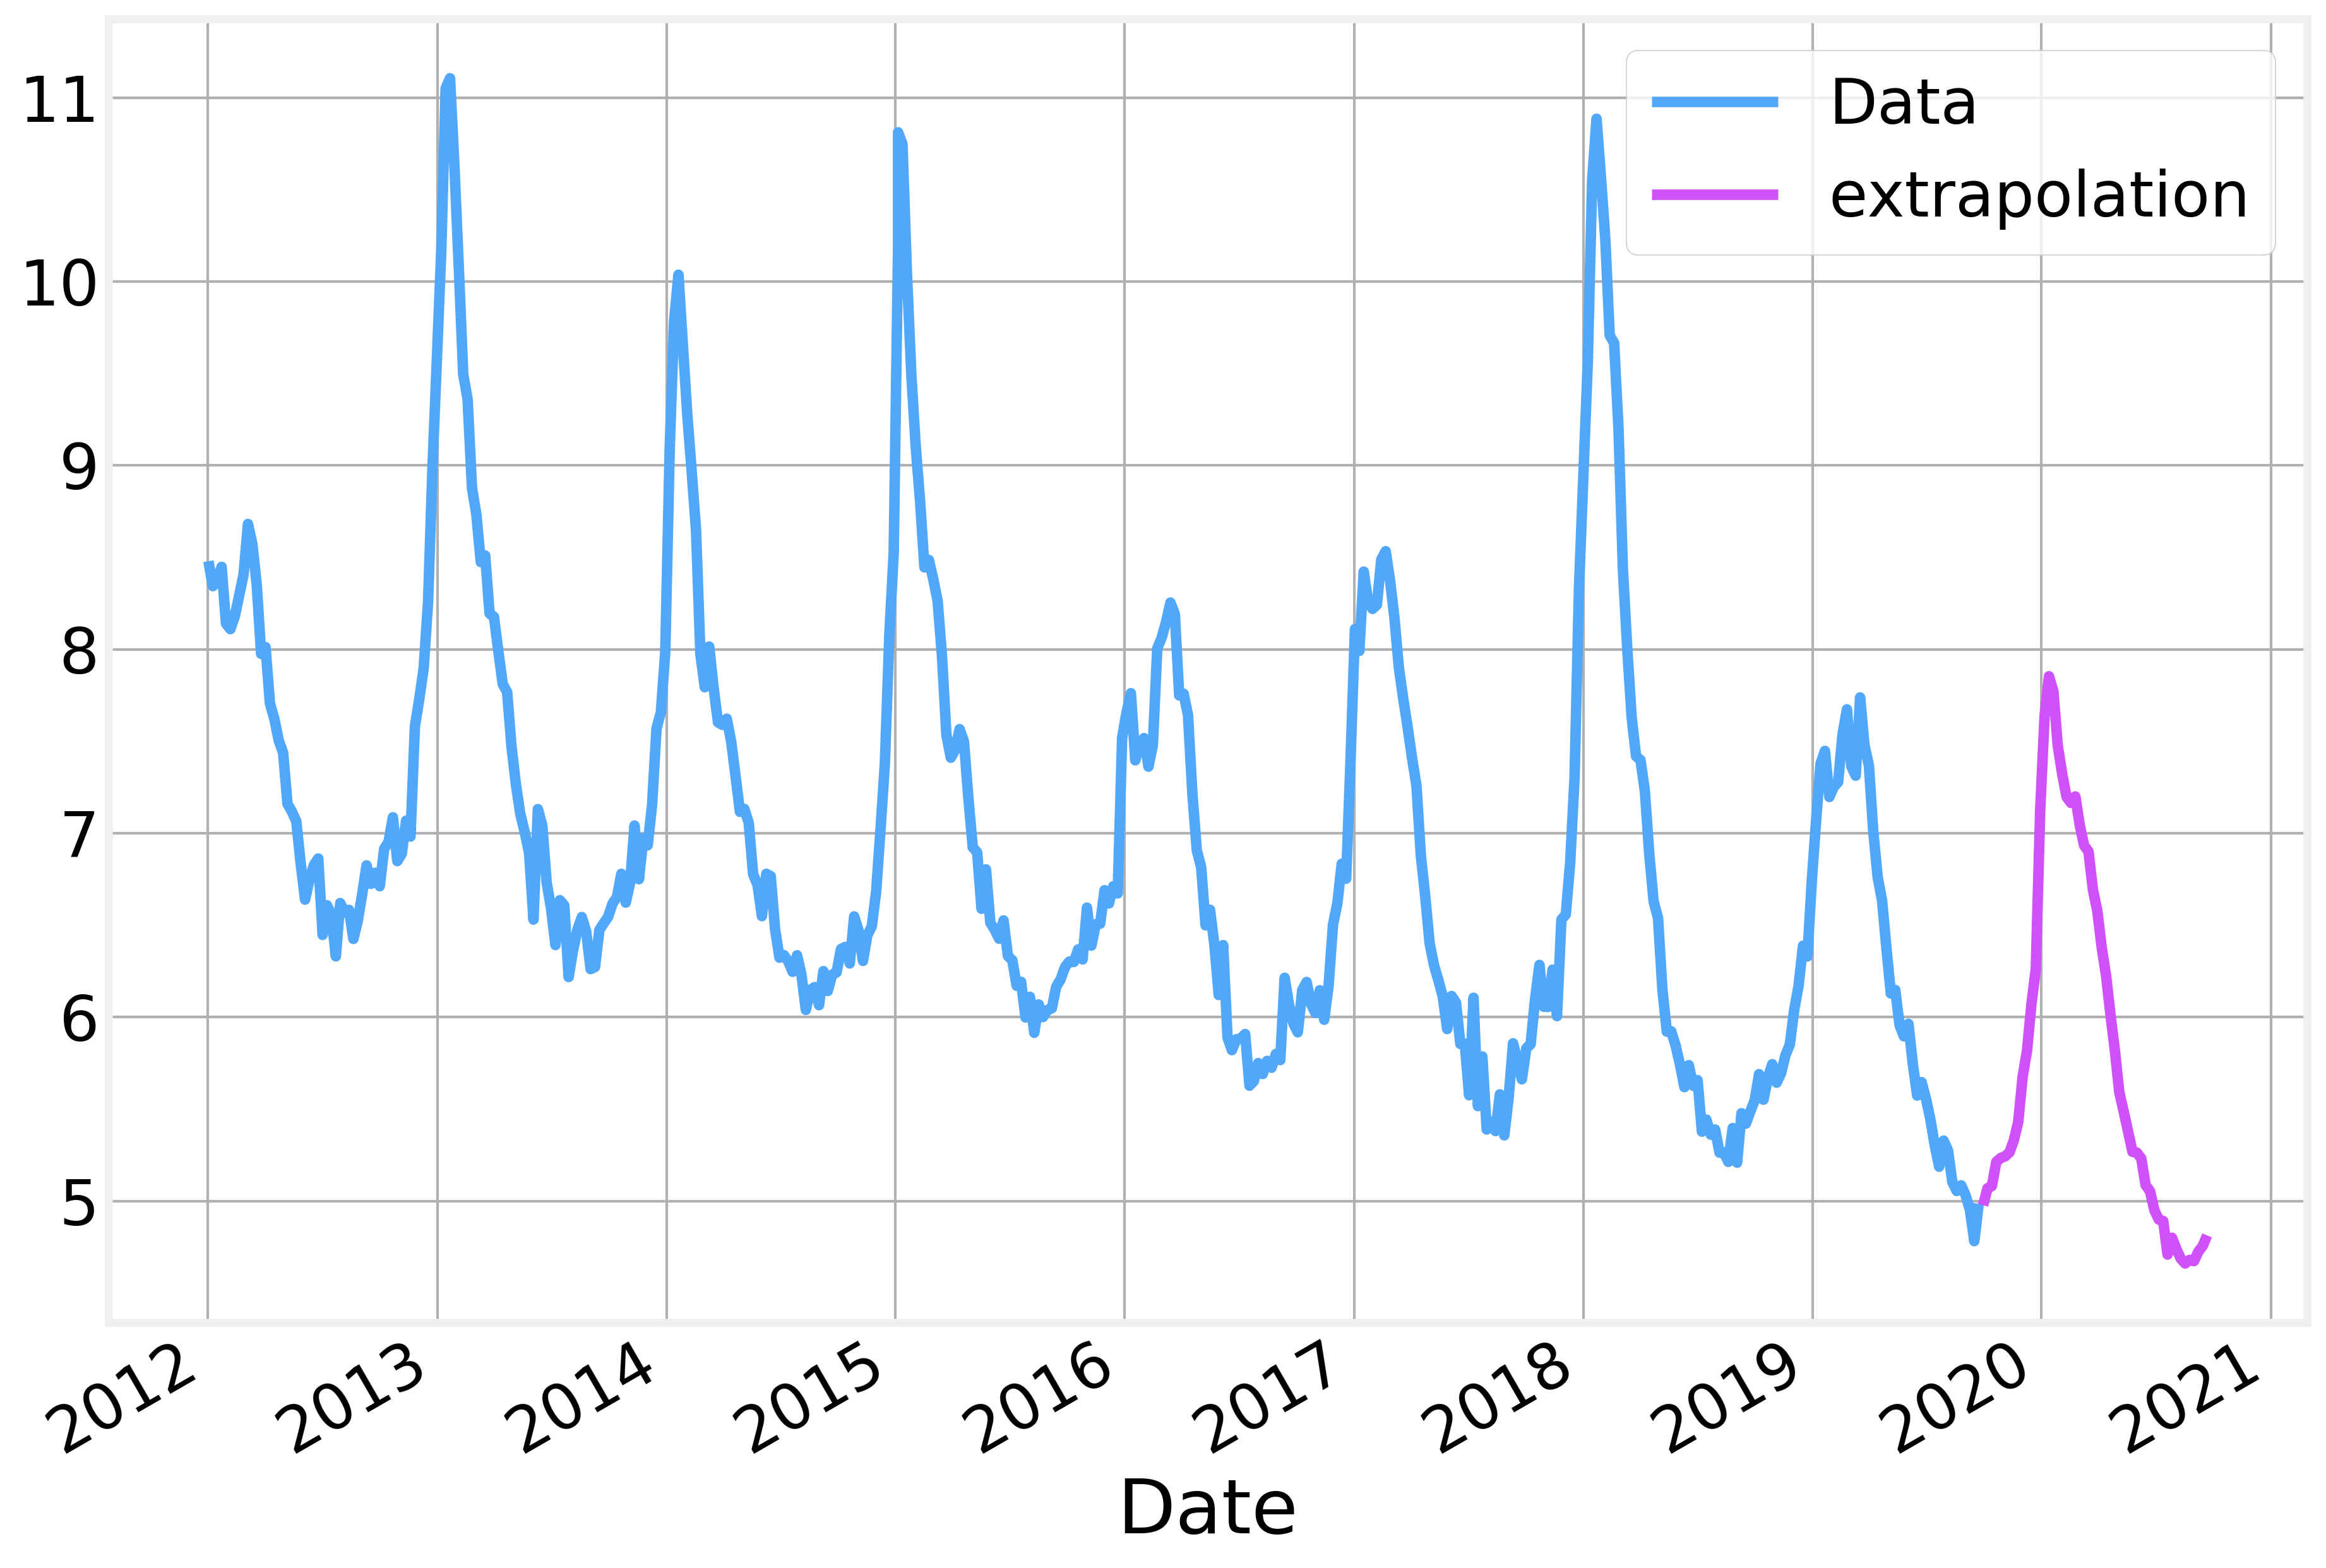

In [25]:
ax = ILI.plot()
forecast = res.forecast(52)
ax.plot(new_weeks, forecast)
ax.legend(['Data', 'extrapolation'])

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>